In [20]:

import time
import copy
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'



In [21]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
# from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

from dicemodel.specs import change_fontsize

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [22]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                             IntegerParameter('vd_switch', 0, 1)
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        # TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR'),
                        TimeSeriesOutcome('SCC')
                        ]


In [23]:
n_scenarios = 2000
n_policies = 50
run = '38_OE'
# run 28 = v7.2 i.e. V(D) switch at both locations, SCC. no prtp_dam range (default 0.00000000001). All outcomes. ------ "VD-switch" instead of "vd_switch", i.e. unused, i.e. results meaningless wrt vd switch. Time series for V(D) shows flatline value 1
# run 29: VD_switch changed to vd_switch in dicemodel.uncertainties, emdd range back to (-1, 0.99) from (-0.5 to 0.99)
# run 30: emdd doesn't seem to have gone below - 0.5. retrying
# 31: Nordhaus OE
# 32: emdd range min corrected -0.1 from -1
# 33-35: Nordhaus OE
# 36: verifying model changes made up to 35
# 36 is also a WCS run from before
# 37: WCS with Nordhaus ref
# 38: OE run

In [24]:

start = time.time()
with MultiprocessingEvaluator(dice_sm, n_processes=16) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=n_policies)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2000 scenarios * 50 policies * 1 model(s) = 100000 experiments
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 70000 cases completed
[MainProcess/INFO] 80000 cases completed
[MainProcess/INFO] 90000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Experiment time is 2 mintues


In [25]:
results = experiments, outcomes

start = time.time()
save_results(results, os.path.join(gz_path, str(run) + str(n_scenarios) + 's_' + str(n_policies) + 'p_' + '.tar.gz'))
end = time.time()

print('Saving time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] results saved successfully to E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\38_OE2000s_50p_.tar.gz
Saving time is 11 mintues


In [7]:
# results = load_results(os.path.join(gz_path,'32_OE2000s_50p_.tar.gz'))
# experiments, outcomes = results

In [152]:
# # experiment debug (number of unique values for each variable)
# experiments.info()
# unique_counts = pd.DataFrame.from_records([(col, experiments[col].nunique()) for col in experiments.columns],
#                           columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
# unique_counts
# # experiments['policy']


# Prepare outcomes as needed

In [ ]:
outcomes.keys()

In [39]:
# Add a 'TIME' outcome for Time series 

TimeLine = []
for i in range(65):
    TimeLine.append(2010+i*5)
# TimeLine
outcomes["TIME"] = np.array([TimeLine])

In [26]:
cleaned_outcome = {}

In [27]:
#  dropping first two steps warm-up period and last 5 steps cooldown period cooldown periods
# outcomes[key].shape from (20000, 65) to (20000,58)

for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

In [ ]:
# pairs 1 = output, temp, damages, consumption, U(C)
# pairs 2 = temp, U(C), V(D), W, SCC 
# pairs 3 = Con, con_g, sdr_con, U(C)
# pairs 4 = damages, sdr_dam, V(D) 
# pairs 5: = temp, con, con_g, U(C), dam, dam_g, V(D), W
# pairs time = temp, U(C), V(D), W, SCC 
# pairs time 2 = con, dam, sdr_con, sdr_dam


In [11]:

cleaned_outcome_pairs_5 = copy.deepcopy(cleaned_outcome)

In [12]:
# remove outcomes that you dont need for pairs plots and time series
rem_list = [
    # 'Atmospheric Temperature',
    # 'Total Output',
    # 'Per Capita Consumption',
    # 'Consumption Growth',
    # 'Utility of Consumption',
    # 'Per Capita Damage',
    # 'Damage Growth',
    # 'Disutility of Damage',
    # 'Welfare',
    'Consumption SDR',
    'Damage SDR',
    'SCC'
]
for key in rem_list:
    cleaned_outcome_pairs_5.pop(key)
    

In [13]:
cleaned_outcome_pairs_5.keys()

dict_keys(['Atmospheric Temperature', 'Per Capita Consumption', 'Consumption Growth', 'Utility of Consumption', 'Per Capita Damage', 'Damage Growth', 'Disutility of Damage', 'Welfare'])

In [28]:
# Values for 2300
end_outcome = {}
for key, value in cleaned_outcome.items():
    end_outcome[key] = value[:, -1]  
# end_outcome['Welfare']
# np.mean(cleaned_outcome['Damage Growth'], axis =0)


# Pairs plotting grouped by policy

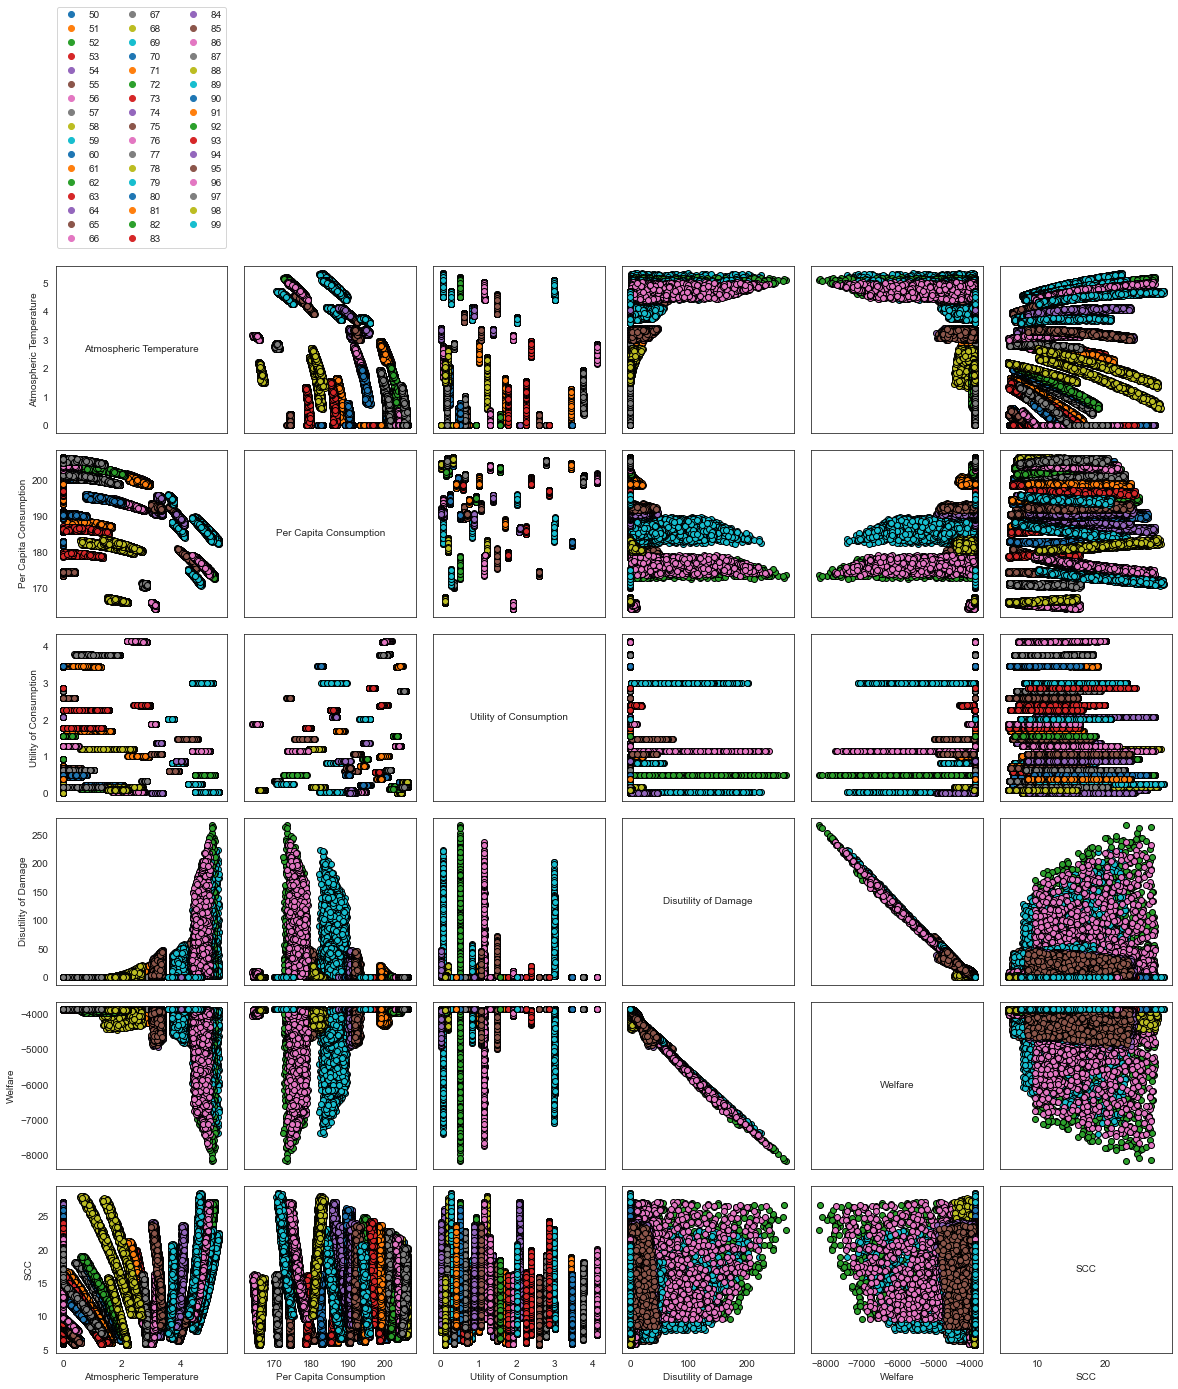

In [47]:

from ema_workbench.analysis import pairs_plotting
fig, axes = ema_workbench.analysis.pairs_plotting.pairs_scatter(experiments, cleaned_outcome,group_by='policy')
fig.set_size_inches(20,20)

# repeat_token = 1
plt.show()

In [48]:
fig.savefig(os.path.join(fig_path, str(run) + '_OE_pairs2_grouped_policy_' + str(repeat_token) + '.png'))

# Pairs ungrouped

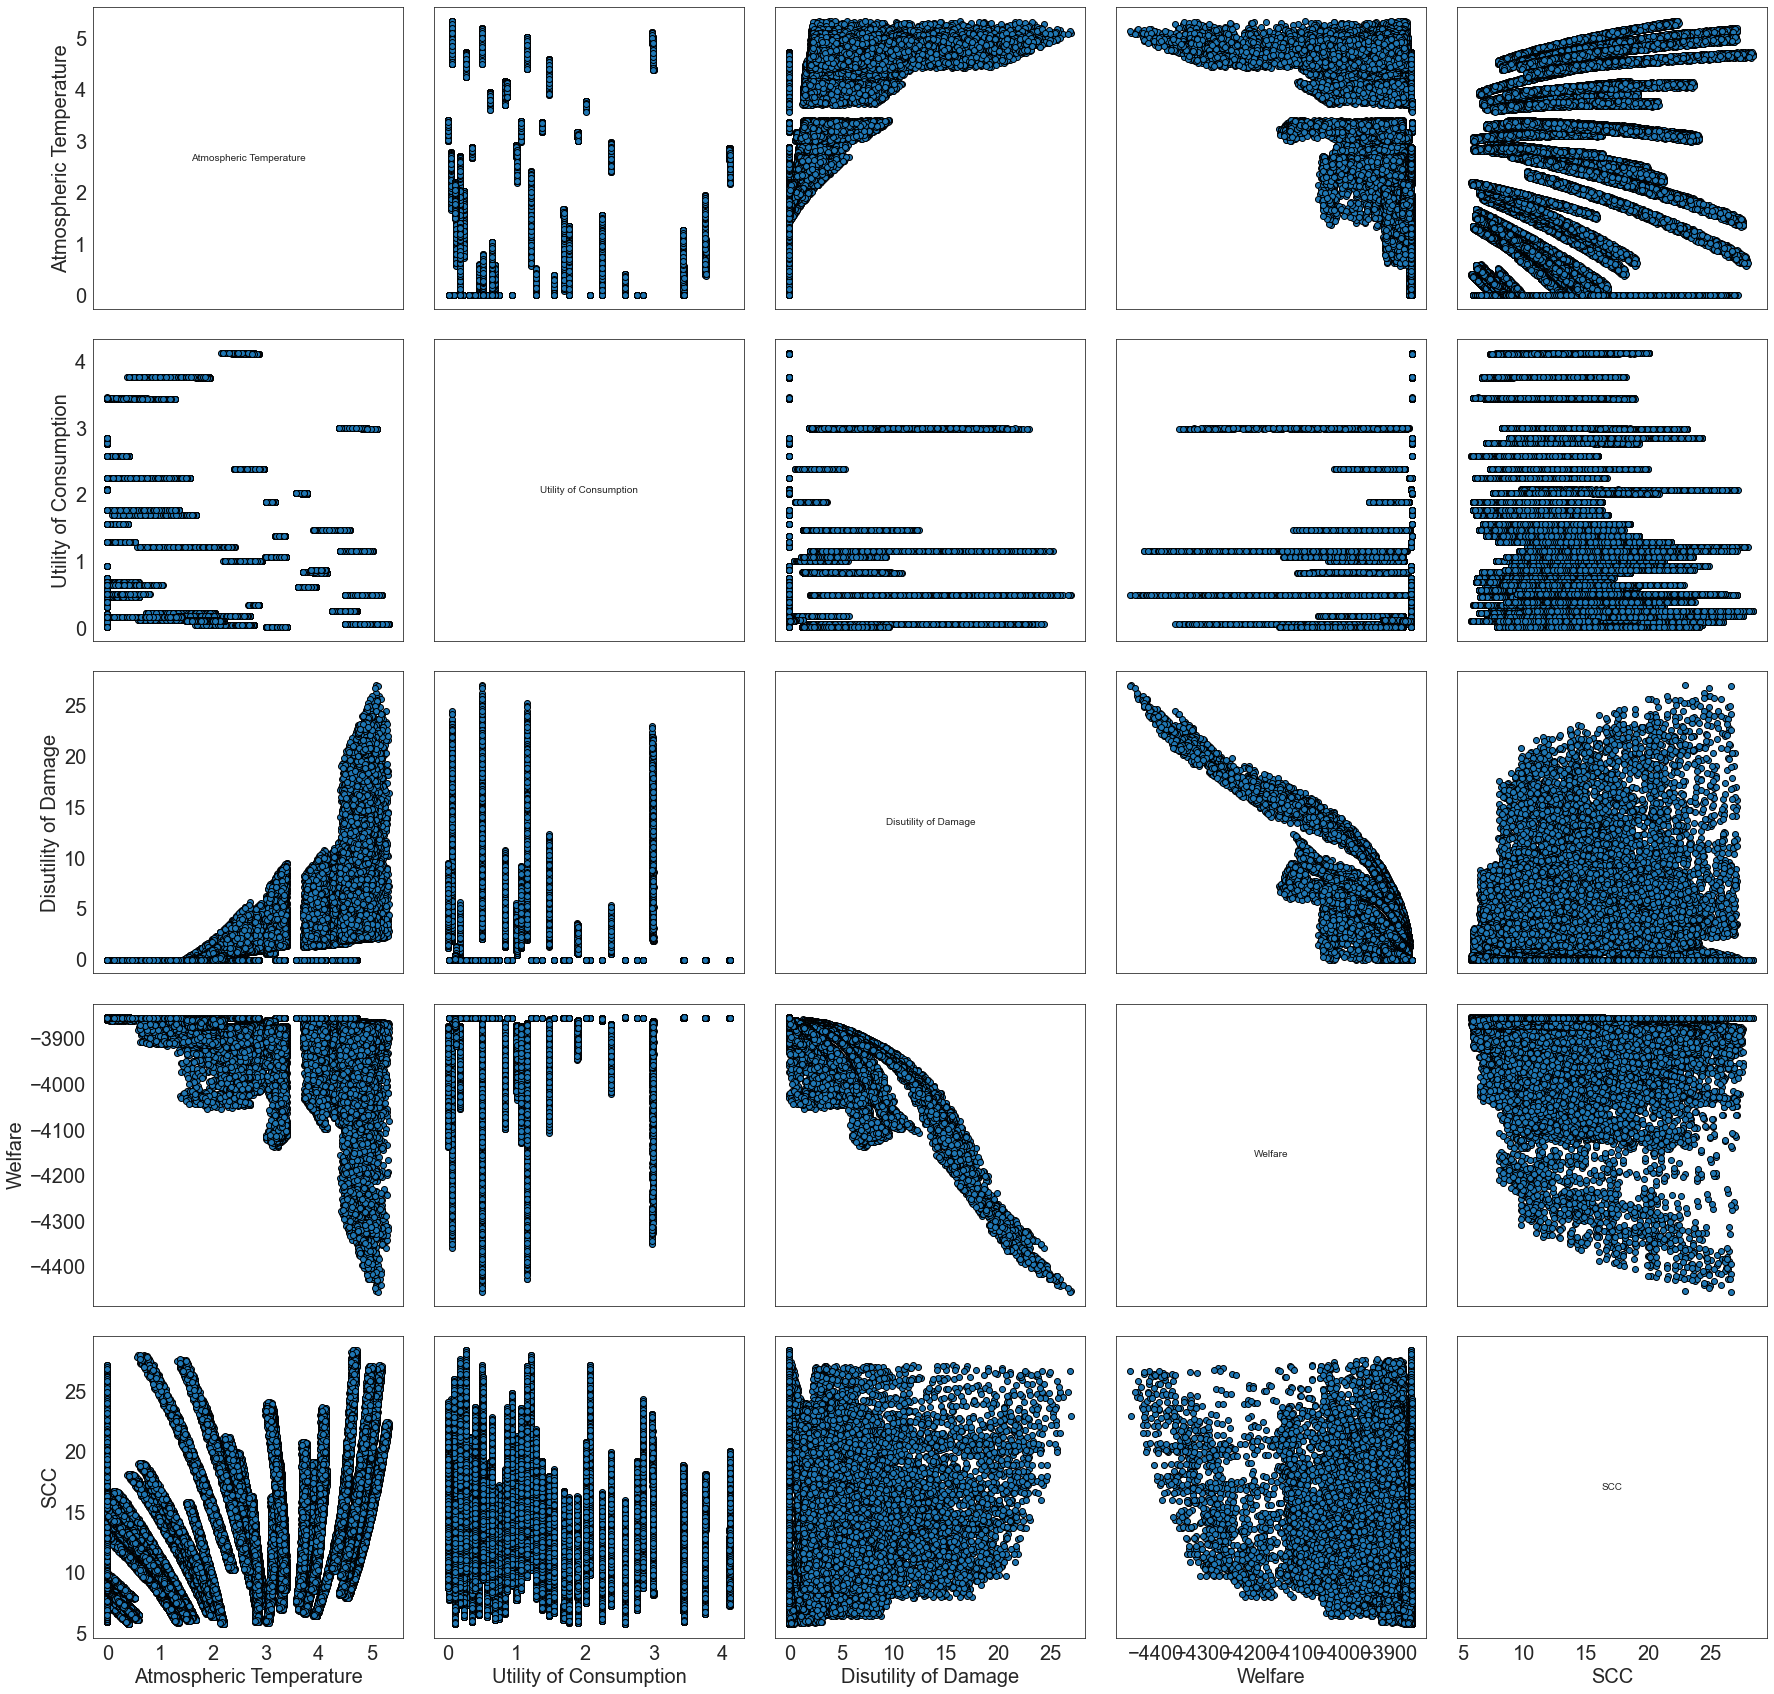

In [111]:
fig, axes = pairs_plotting.pairs_scatter(experiments,cleaned_outcome_pairs_3, legend=True, transparent=True)
fig.set_size_inches(30,30)
change_fontsize(fig, fs=20)
plt.show()

In [112]:
fig.savefig(os.path.join(fig_path, str(run) + 'OE_pairs_ungrouped' + str(n_scenarios) + 's' + str(n_policies) + 'p_'+ 'pairs2_' + 'fs20' +  '.png'))


# Pairs plotting using ema workbench grouped by V(D) switch on/ off

In [29]:
grouping_specifiers = {'without V(D)':0, 'with V(D)':1}
grouping_labels = sorted(grouping_specifiers.keys())
grouping_specifiers_VD = [grouping_specifiers[key] for key in
                                       grouping_labels]


In [30]:
print(grouping_specifiers_VD)
print(grouping_labels)

[1, 0]
['with V(D)', 'without V(D)']


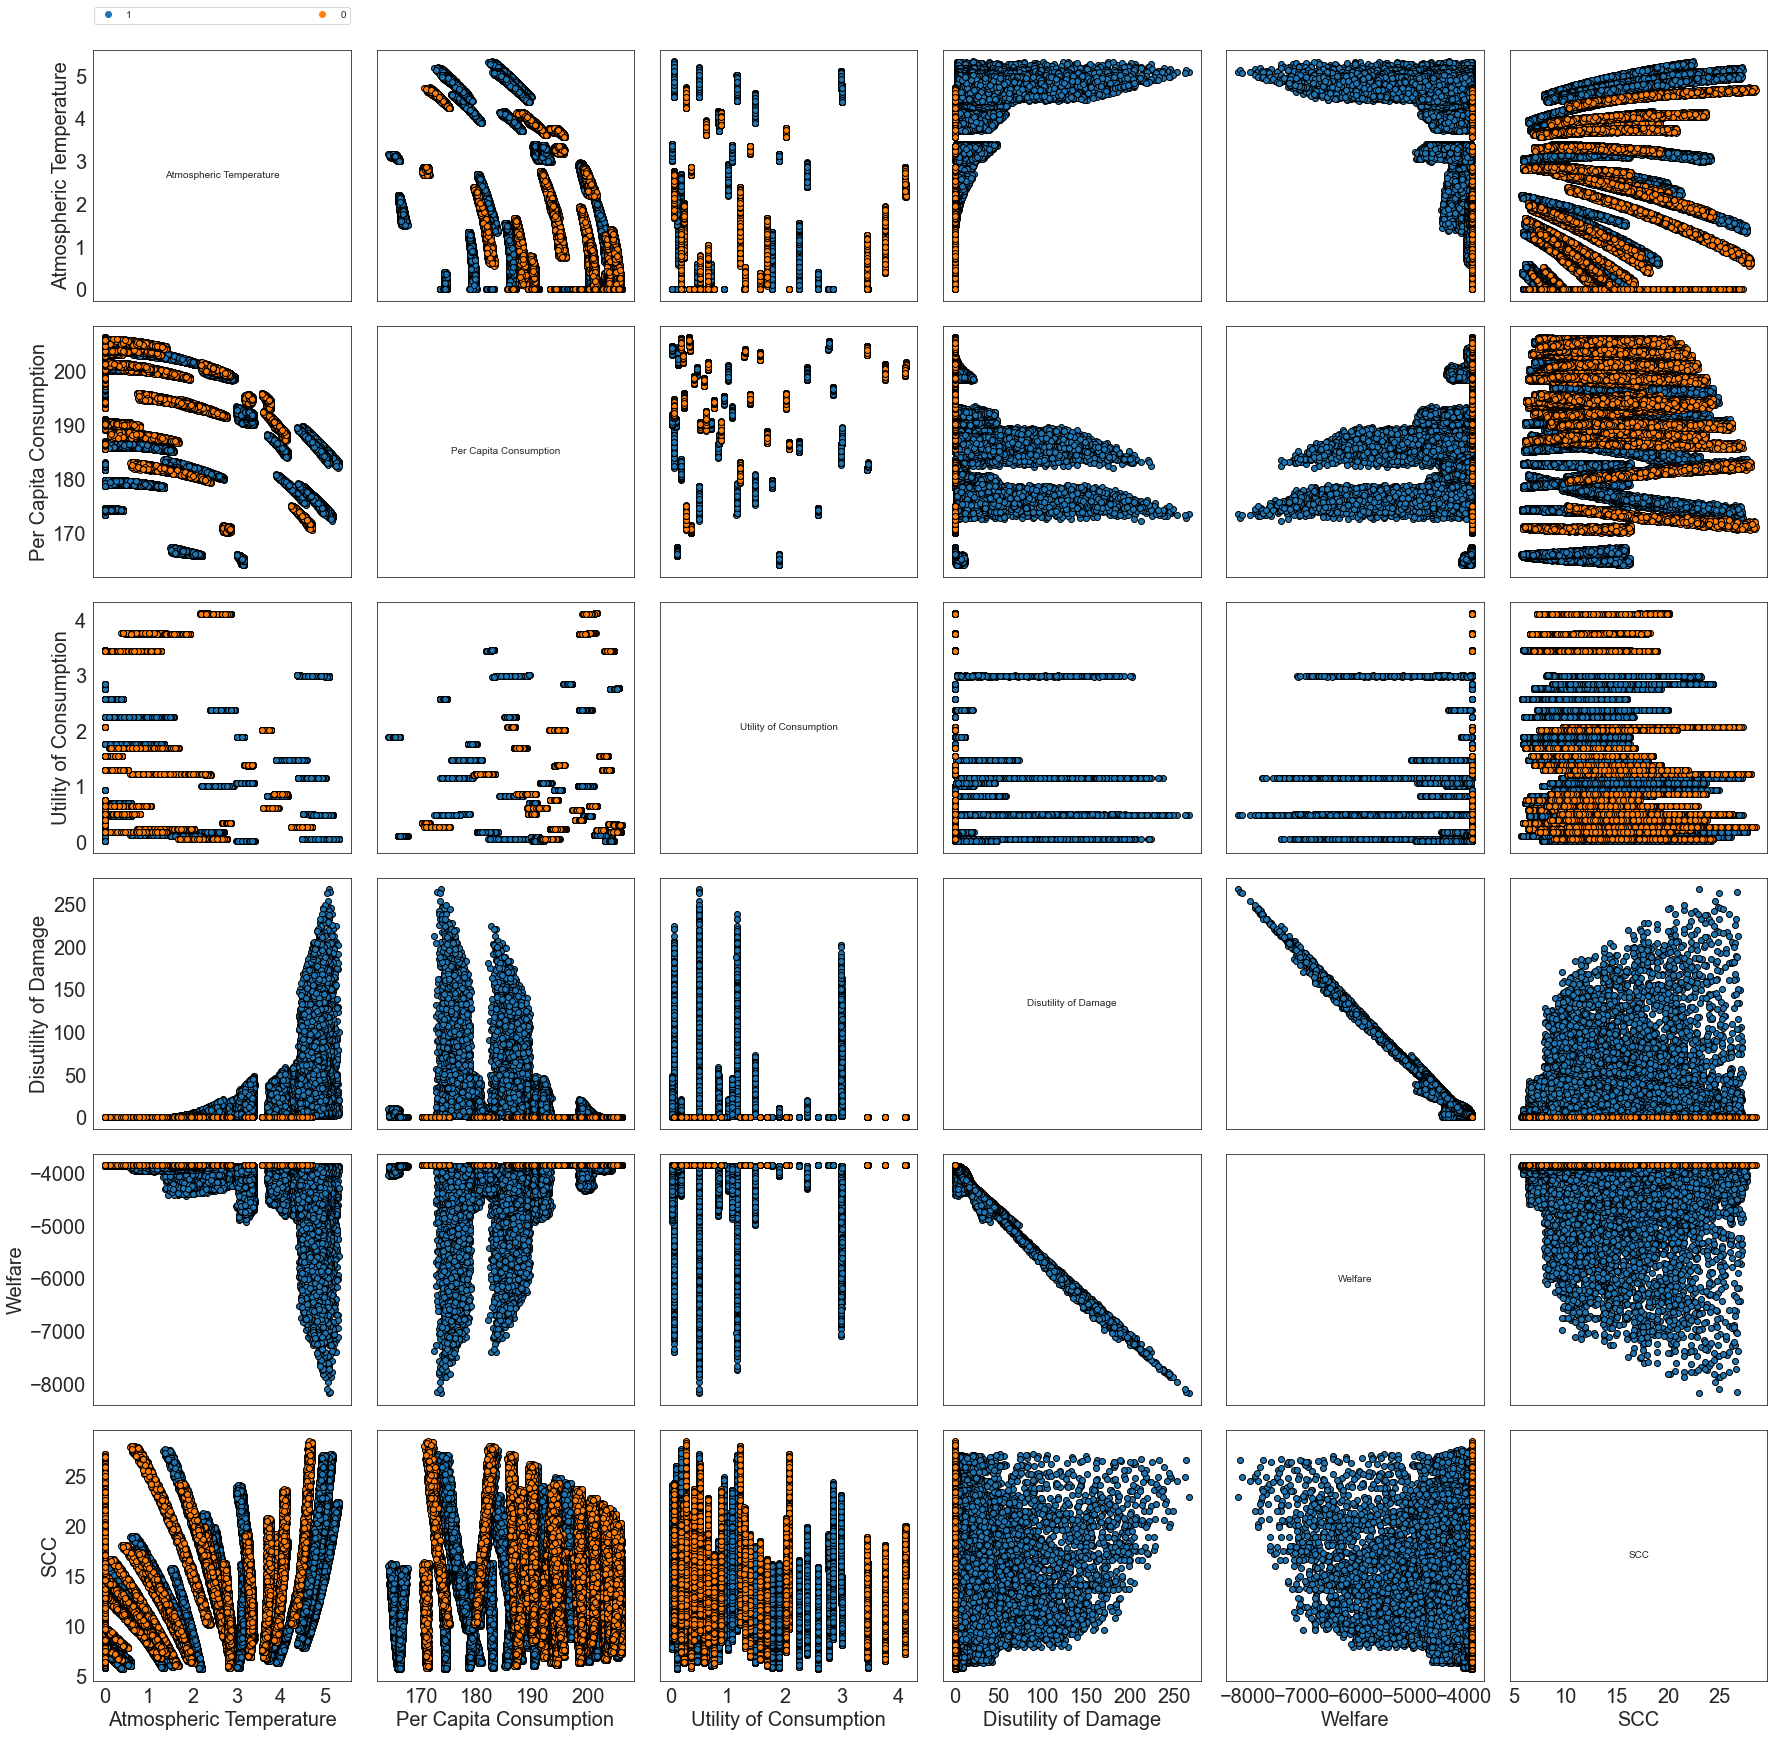

In [51]:
fig, axes = pairs_plotting.pairs_scatter(experiments,cleaned_outcome_pairs_2, group_by='vd_switch',grouping_specifiers=grouping_specifiers_VD, legend=True, transparent=True)
fig.set_size_inches(30,30)
change_fontsize(fig, fs=20)
plt.show()


In [52]:
fig.savefig(os.path.join(fig_path, str(run) + '_pairs_by_VDswitch_ema' + str(n_scenarios) + 's' + str(n_policies) + 'p_'+ 'pair3_' + 'fs20' +  '.png'))


# Pairs plotting using ema workbench grouped by emdd range intervals 
(this isn't really working out)

In [31]:
grouping_specifiers_emdd = {'-0.99 to -0.5': -0.5, '-0.5 to 0': -0, '0 to 0.5': 0.5,'0.5 to 1': 1, '1 to 2': 2}
grouping_labels = sorted(grouping_specifiers.keys())
grouping_specifiers = [grouping_specifiers[key] for key in
                                       grouping_labels]


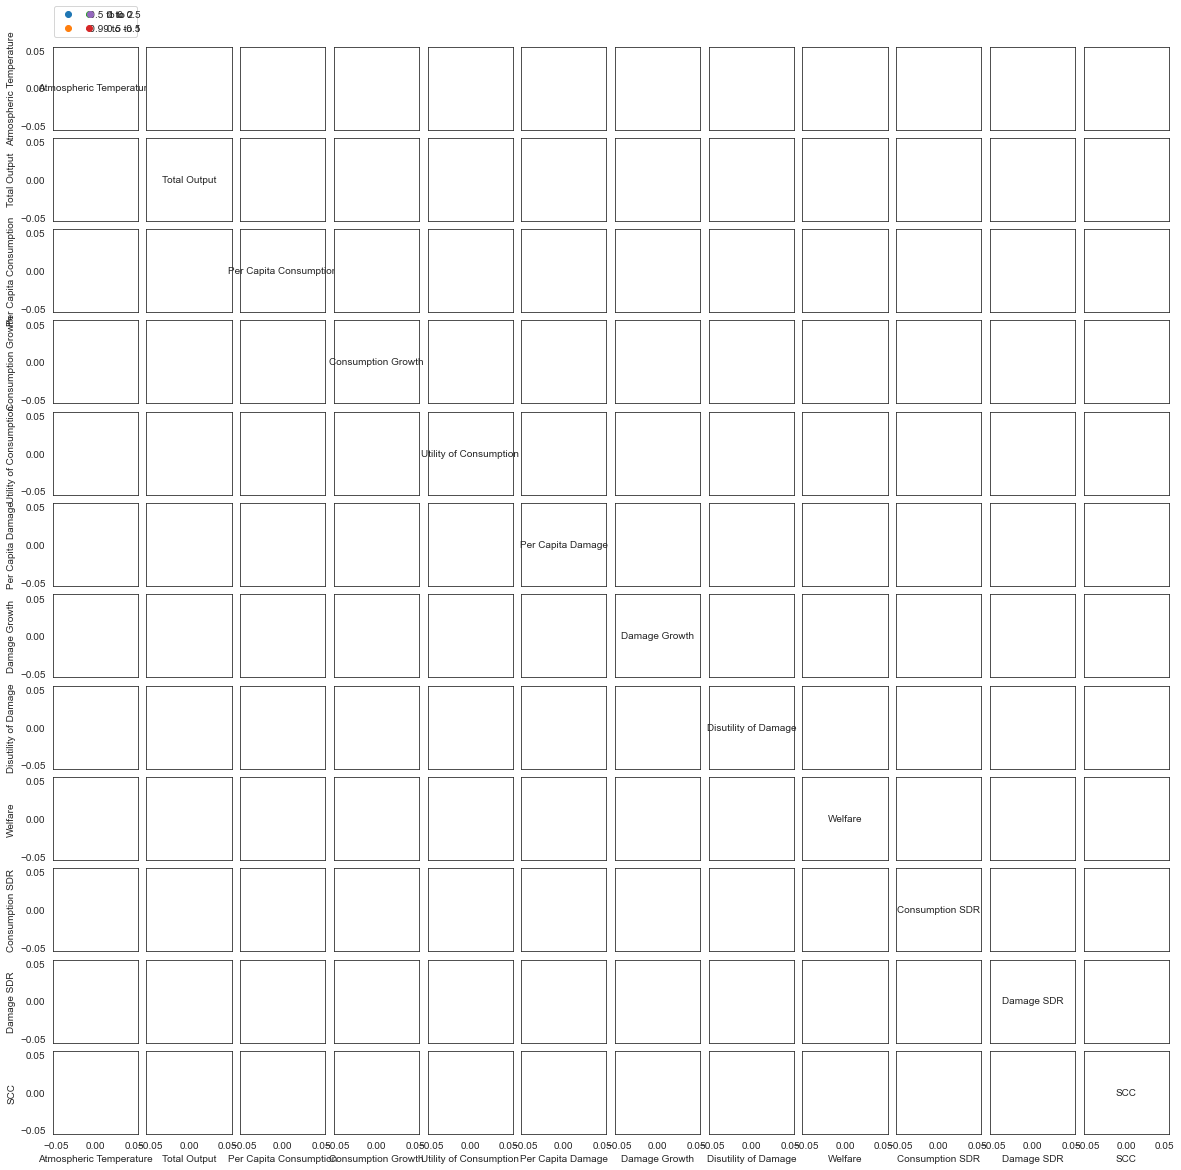

In [32]:
from ema_workbench.analysis import pairs_plotting, plotting_util
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='emdd',grouping_specifiers=grouping_specifiers_emdd, 
legend=True, 
)
change_fontsize(fig, fs=20)
fig.set_size_inches(20,20)
plt.show()

In [ ]:
fig.savefig(os.path.join(fig_path, str(run) + '_pairs_by_VDswitch_ema' + str(n_scenarios) + 's' + str(n_policies) + 'p_'+ 'pair3_' + 'fs20' +  '.png'))


# Pairs plotting by EMDD range through sns

In [ ]:
# # RealParameter('emdd', -1.0, 0.99)
# out_DF['emdd'] = out_DF['emdd'].apply(lambda x: 'Sub Zero' if x < 0 else 'Over Zero')

In [91]:
clr_palette = ([sns.cubehelix_palette(8)[6],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[10]])

In [53]:
out_DF = pd.DataFrame(end_outcome)
out_DF.head()
emdd = experiments['emdd']
out_DF['emdd'] = emdd

ValueError: arrays must all be same length

In [145]:
out_DF['emdd'] = out_DF['emdd'].apply(
    lambda x: '-1 to -0.5' if x < -0.5
        else('-0.5 to 0' if (x < 0)
            else('0 to 0.5' if (x < 0.5)
                else ('0.5 to 0.99')
                )
            )
    )

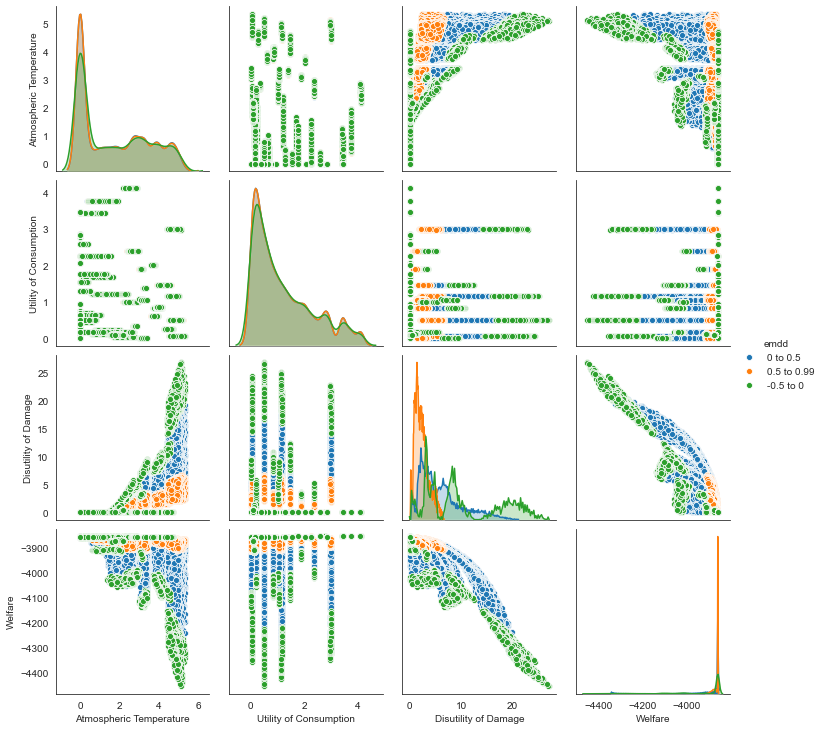

In [146]:
sns_plot = sns.pairplot(out_DF, hue='emdd', vars=list(end_outcome.keys())) # palette=clr_palette
fig.set_size_inches(20, 20)
change_fontsize(fig, fs=20)
sns_plot.savefig(os.path.join(fig_path, str(run) + '_sns_pairs2_by_emdd_2330' +'.png'))
plt.show()

In [ ]:
# Time Series Clustering

In [ ]:
# noutcomes = {}
# for i in range(int(len(outcomes.keys())/5)):
#     arr = np.stack((outcomes[x] for x in list(outcomes.keys())[i::4]), axis=-1)
#     key = list(outcomes.keys())[i][:-5]
#     noutcomes[key] = arr
# noutcomes_wo_time = noutcomes.copy()

# Time Series Plotting

In [ ]:
# Add a 'TIME' outcome 
TimeLine = []
for i in range(65):
    TimeLine.append(2010+i*5)
# TimeLine
outcomes["TIME"] = np.array([TimeLine])
# cleaned_outcome["Welfare"].shape

In [14]:
# Ungrouped Time series

for outcome in cleaned_outcome_pairs_time:
    fig,axes=plotting.lines(experiments, cleaned_outcome_pairs_time, 
    outcomes_to_show= outcome, density=plotting.Density.BOXENPLOT, legend=True)
    
    fig.set_size_inches(25,10)
    change_fontsize(fig, fs=20)
    fig.savefig(os.path.join(fig_path, str(run) + '_v7_TimeSeries_' + str(outcome) + '.png'))
plt.show()

KeyError: 'TIME'

In [33]:
grouping_specifiers_VD = {'without V(D)':0, 'with V(D)':1}
grouping_labels_VD = (grouping_specifiers_VD.keys())

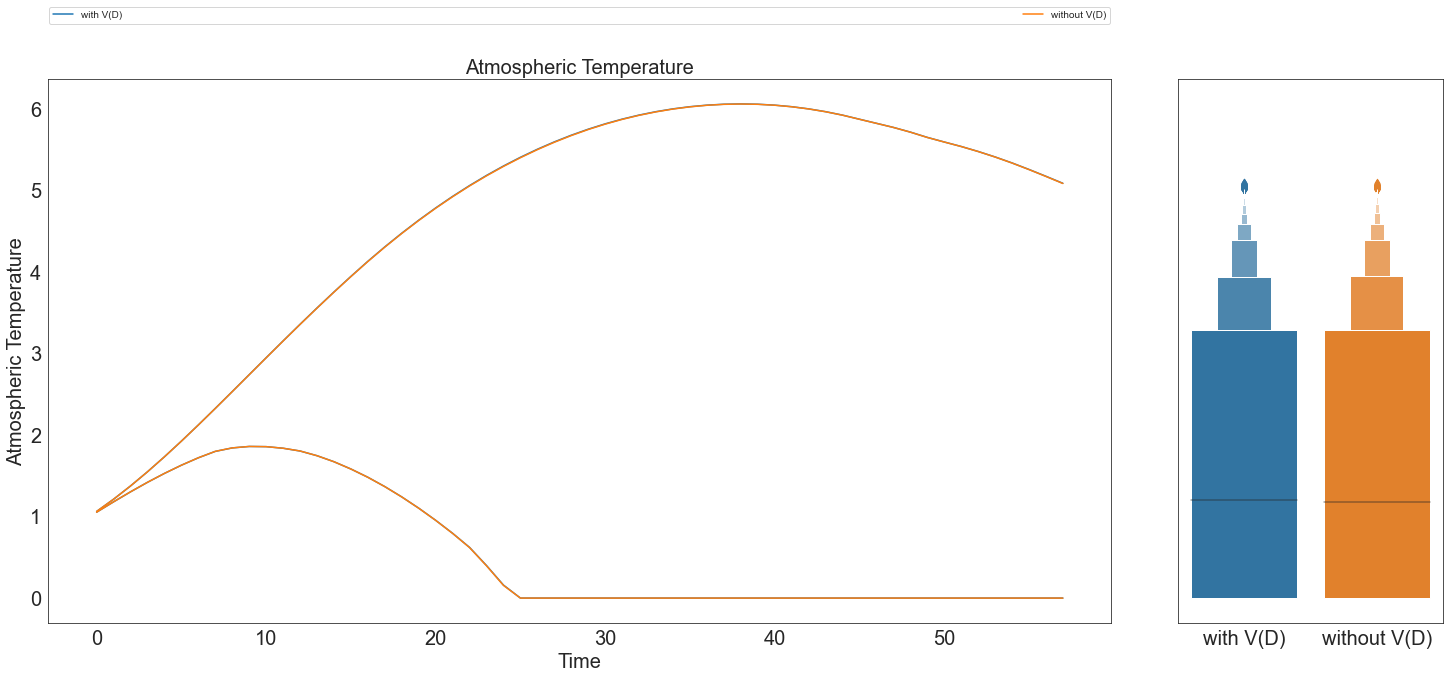

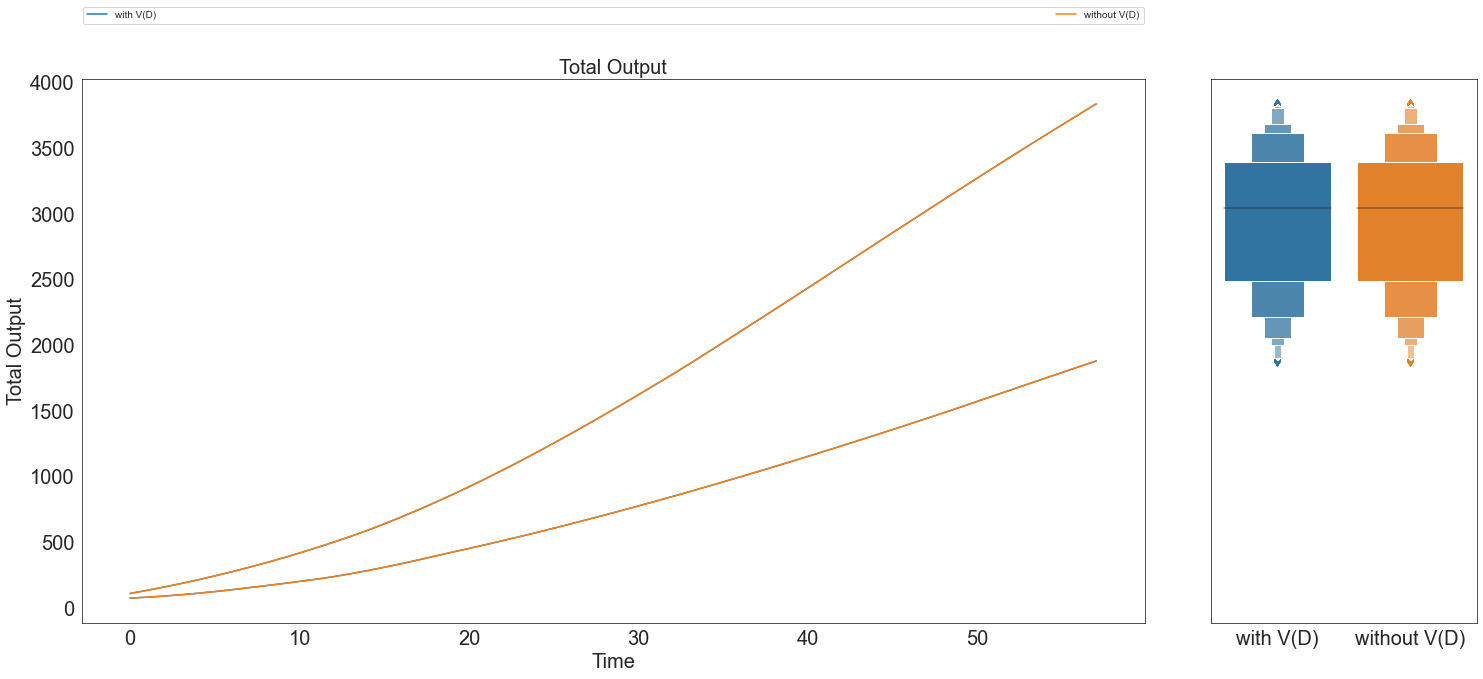

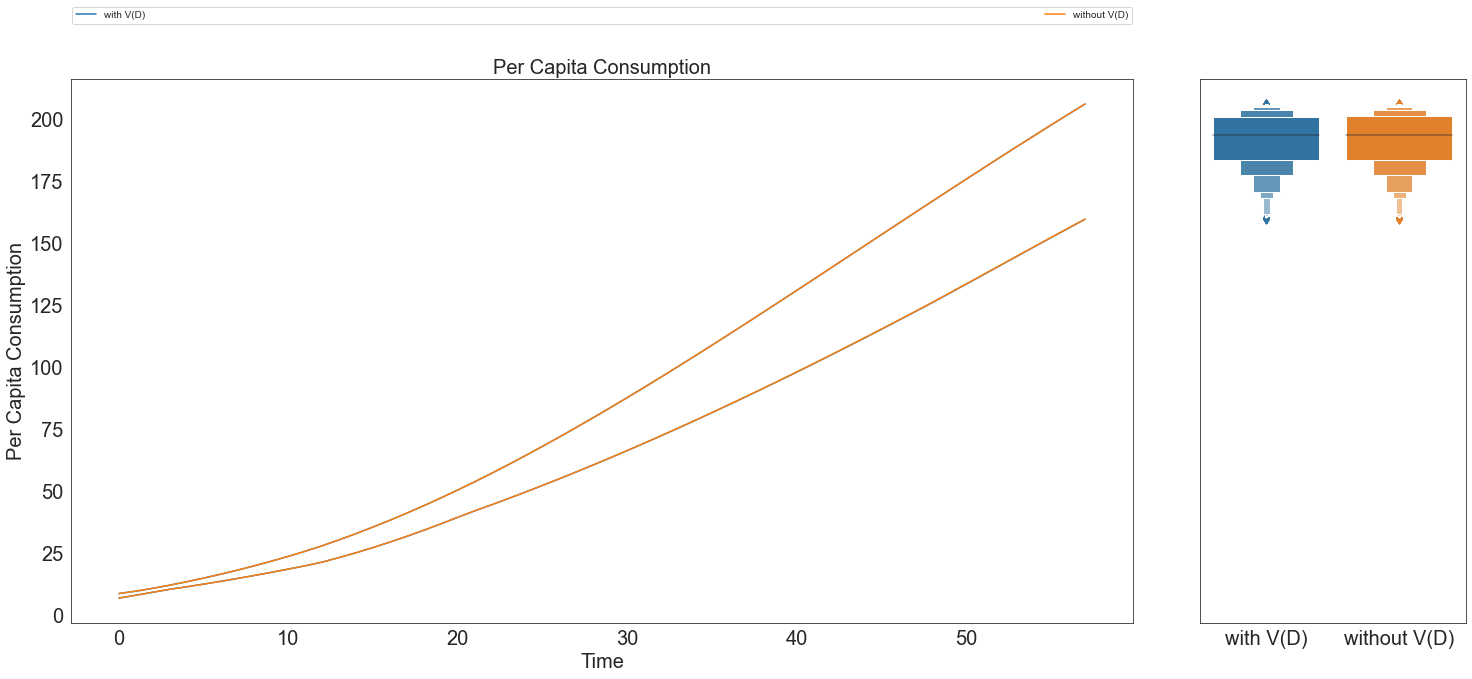

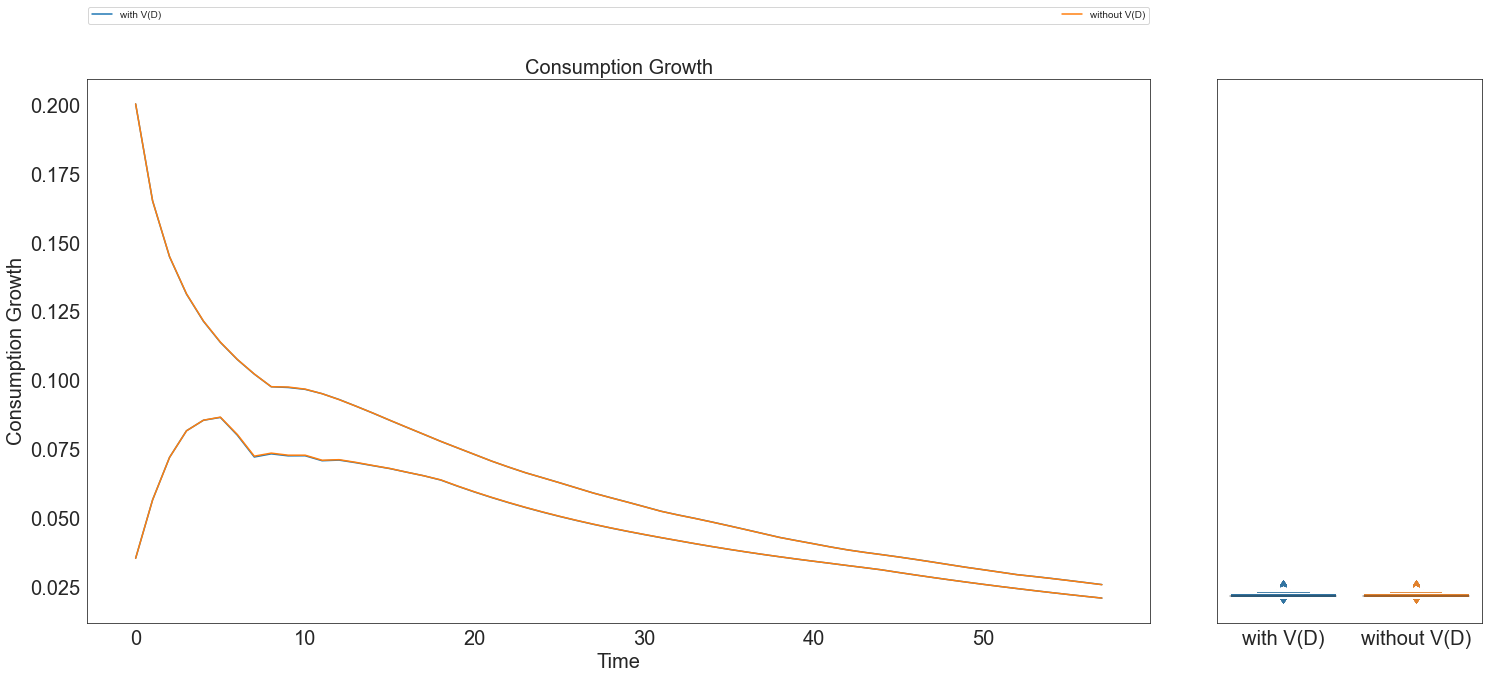

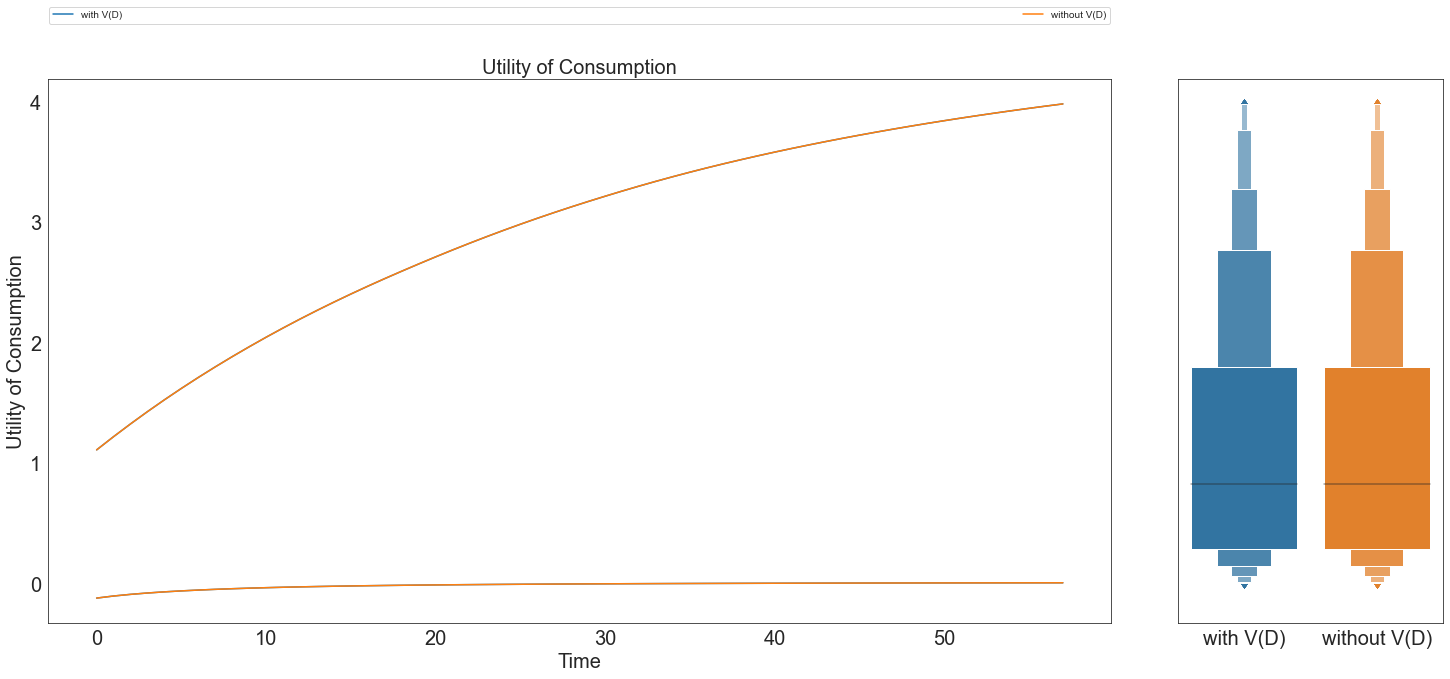

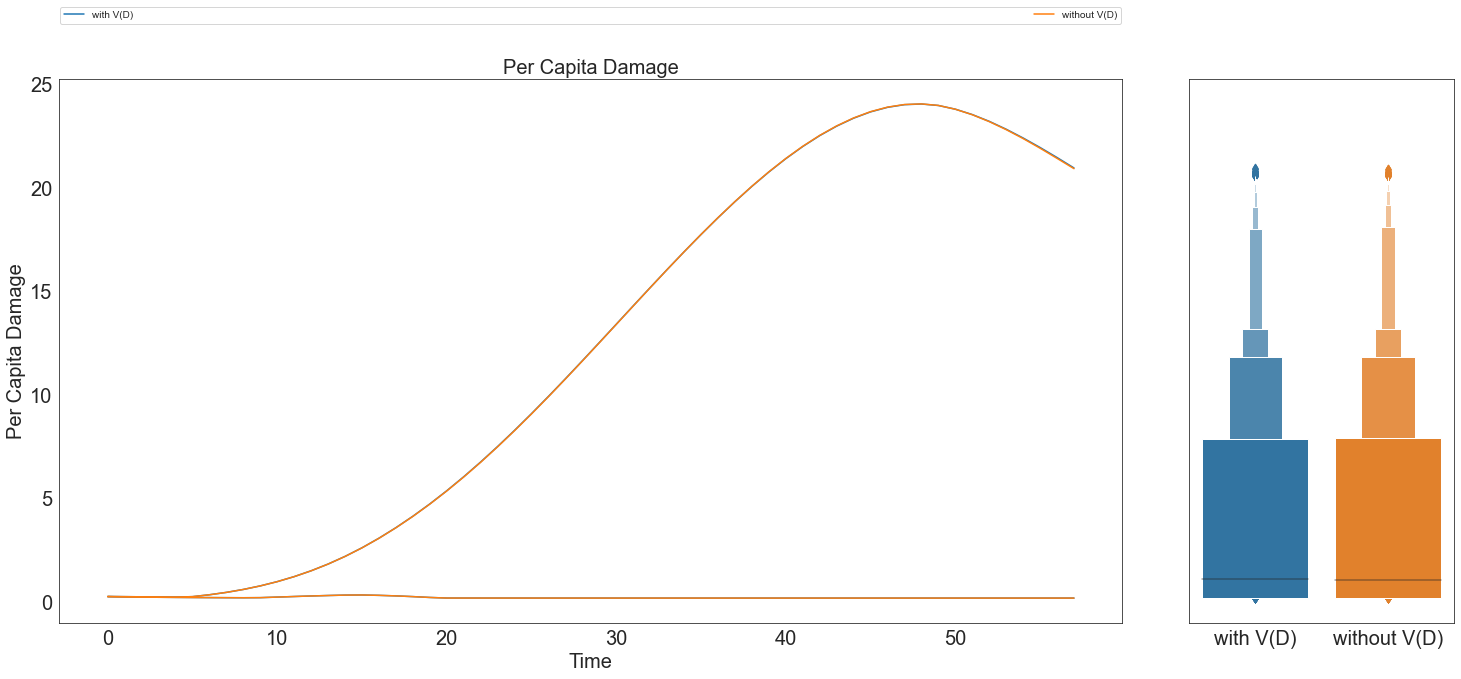

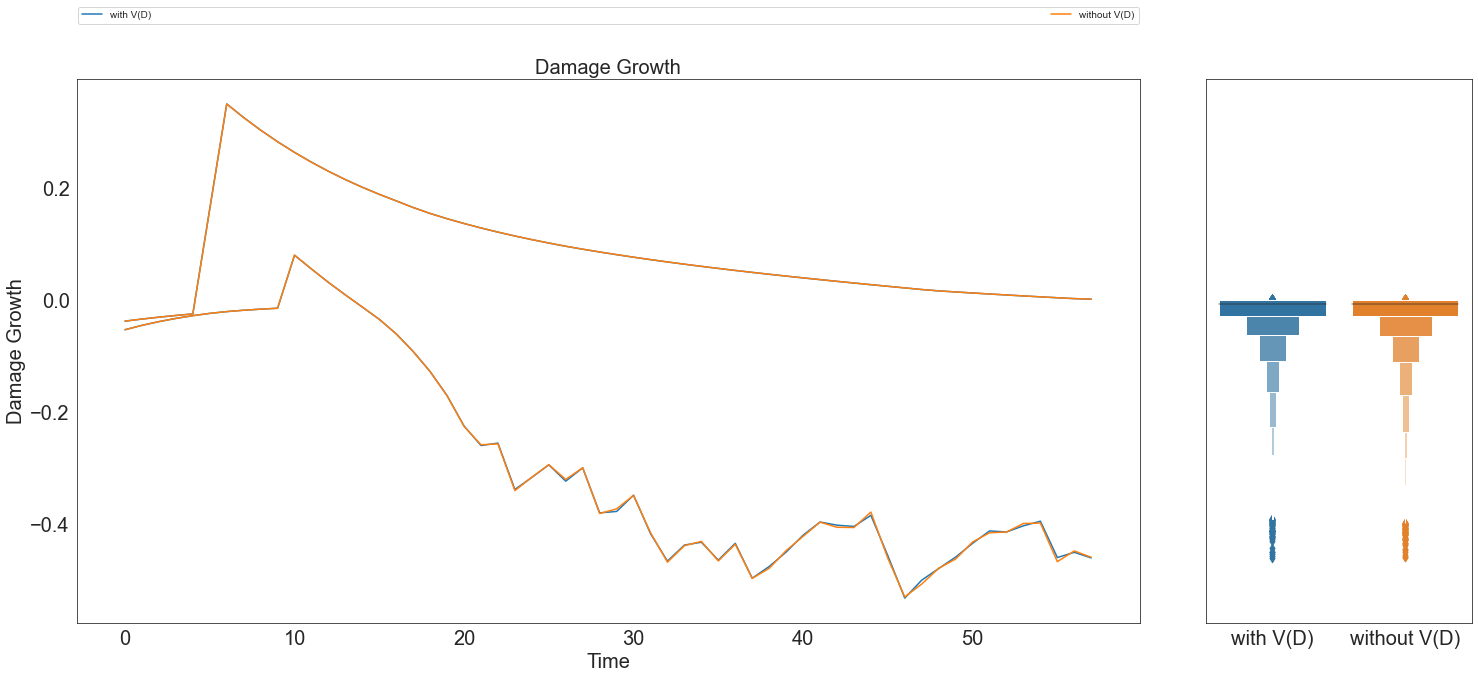

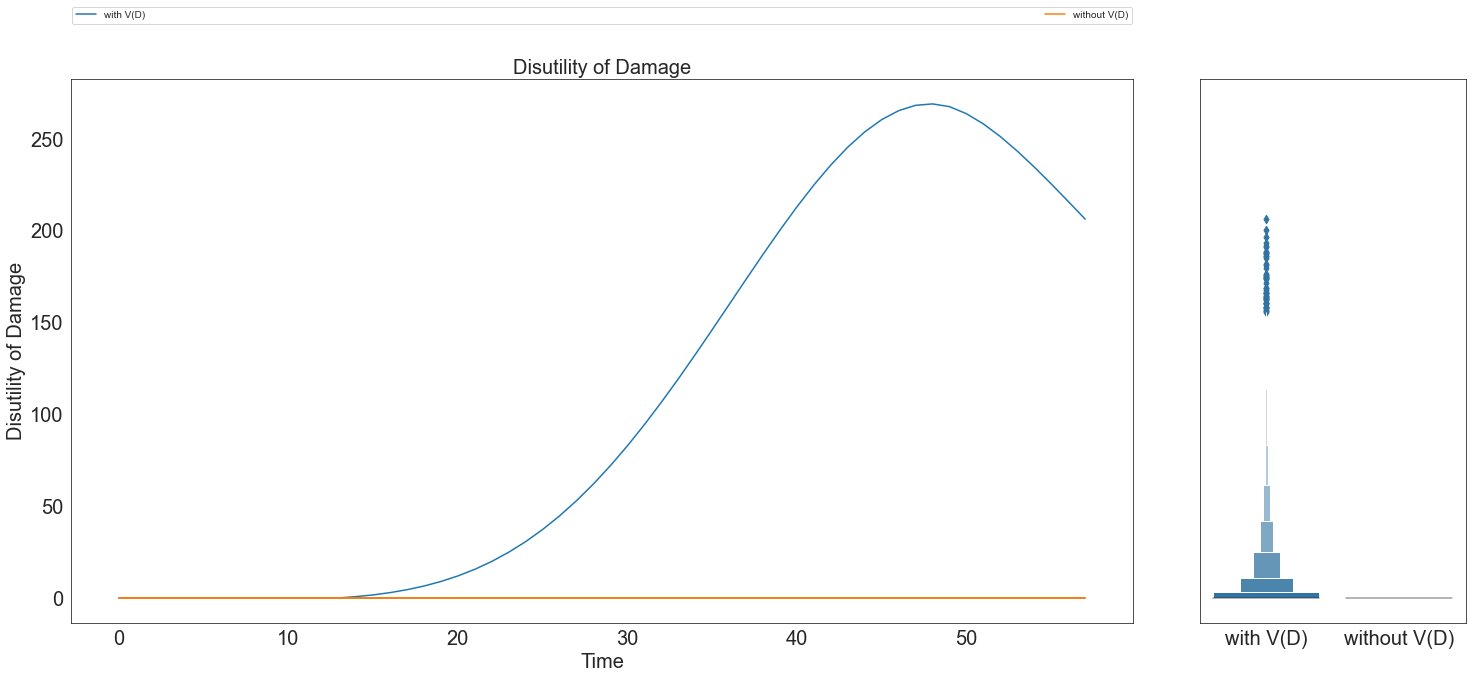

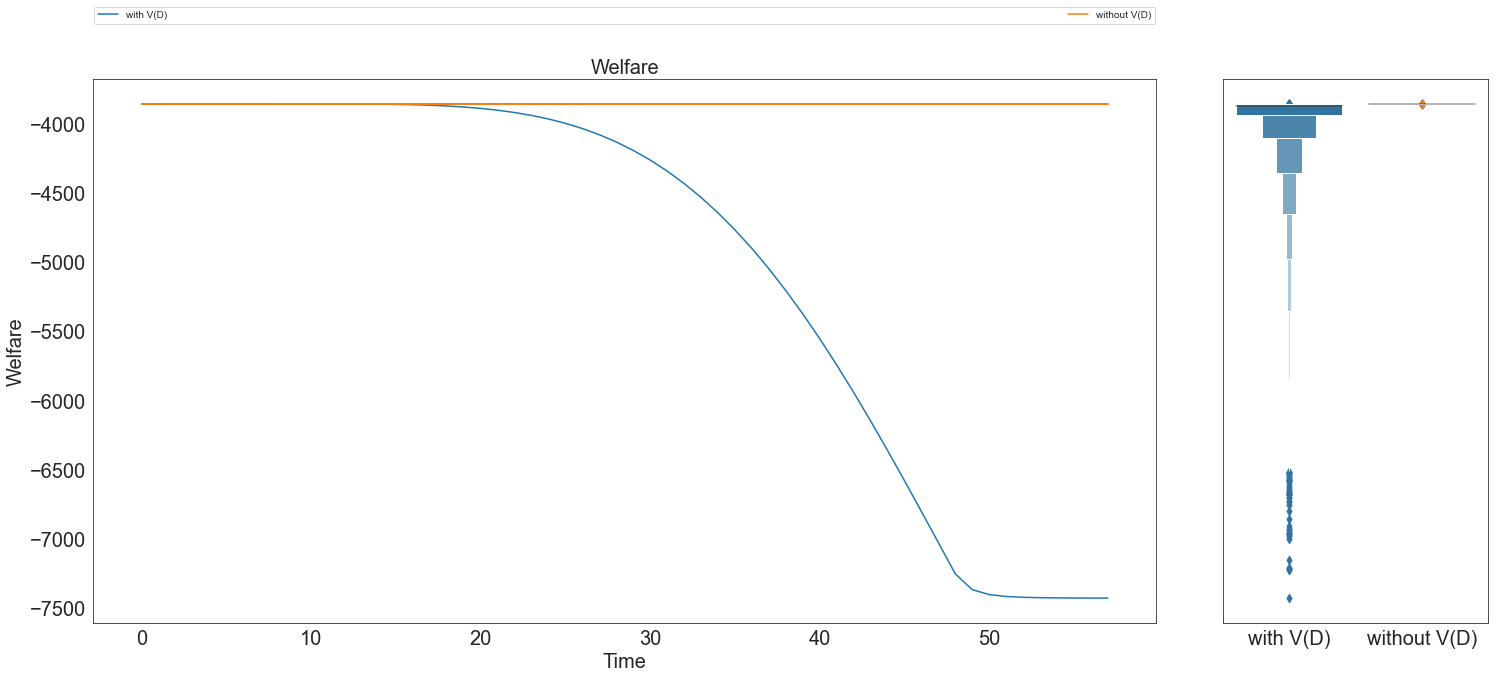

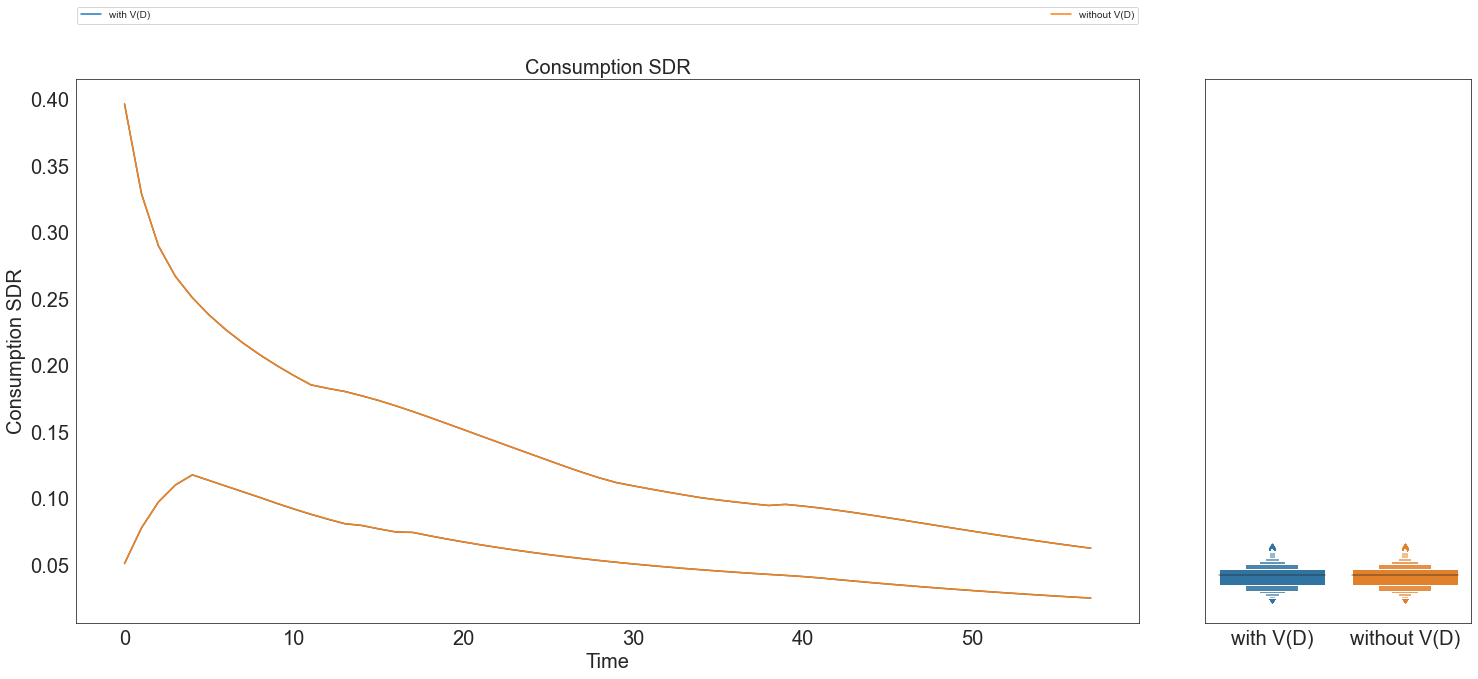

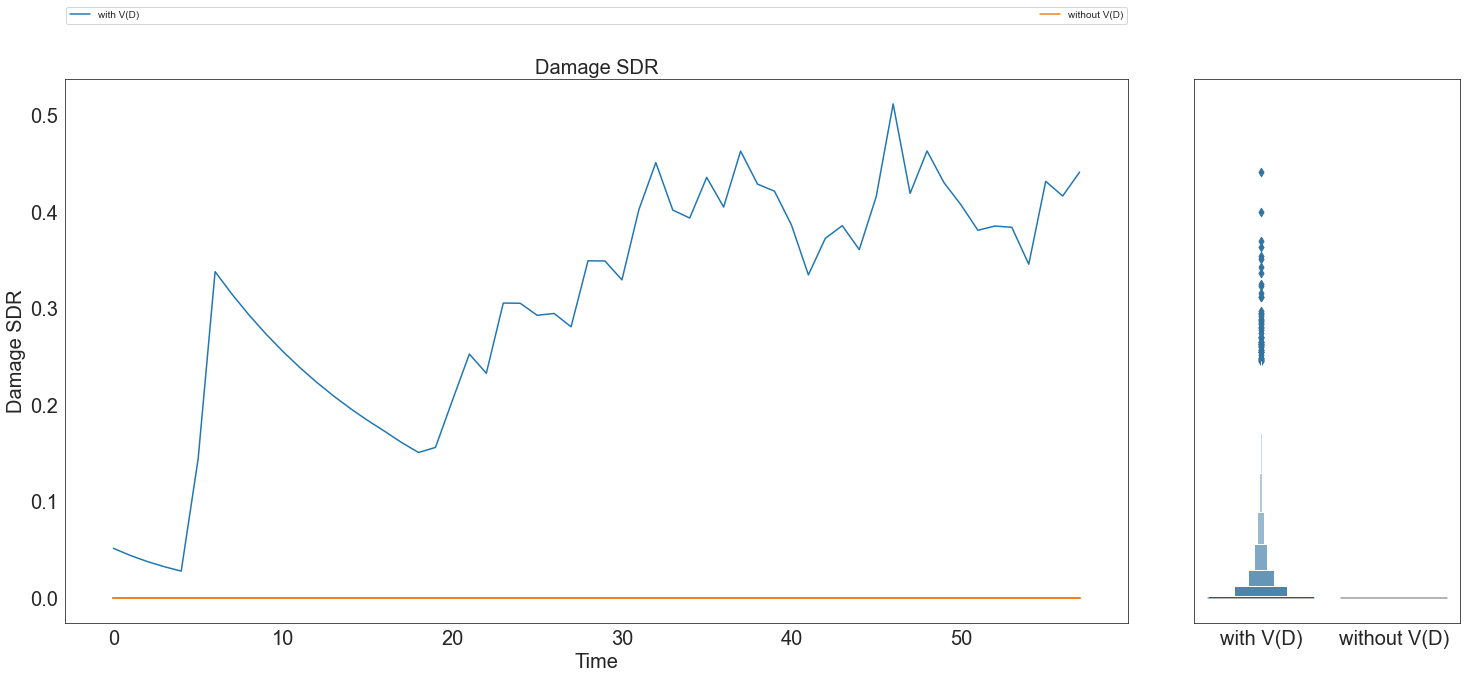

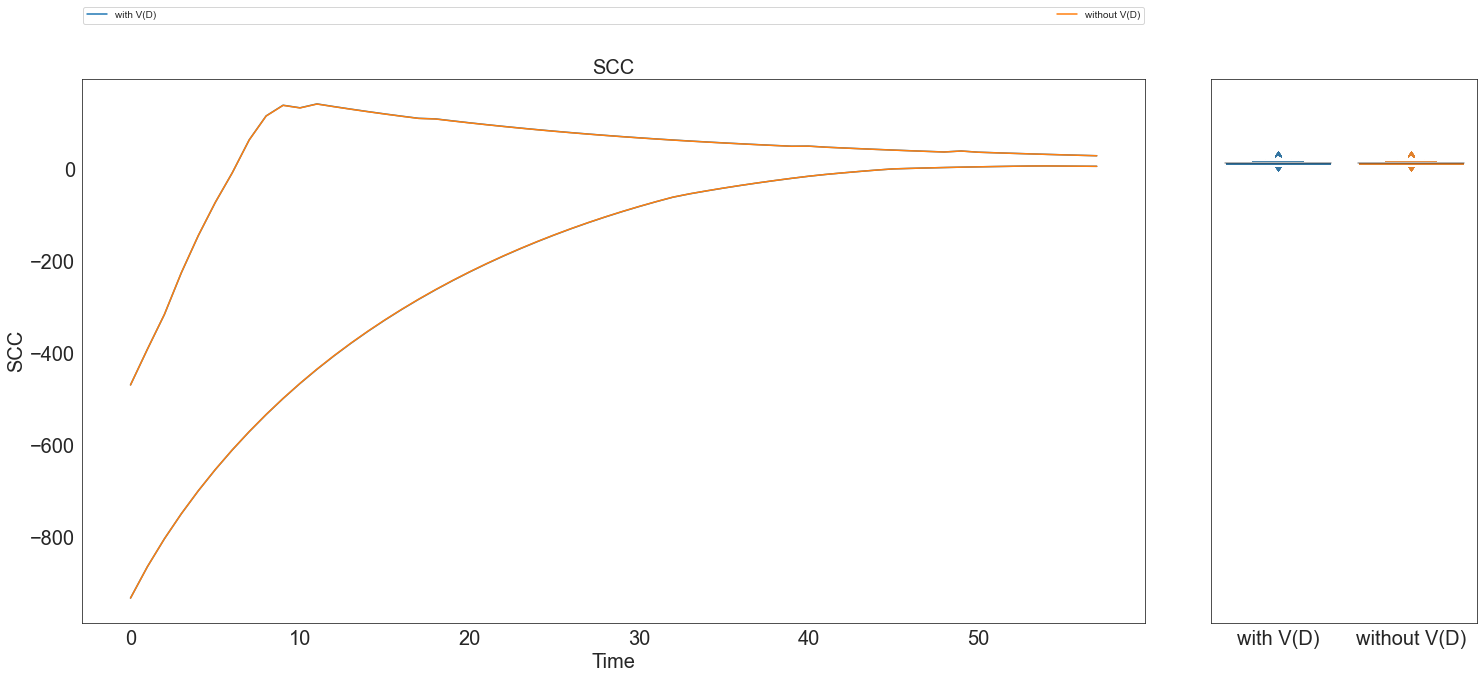

In [34]:
# Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    # repeat_token = 2
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '.png'))
plt.show()


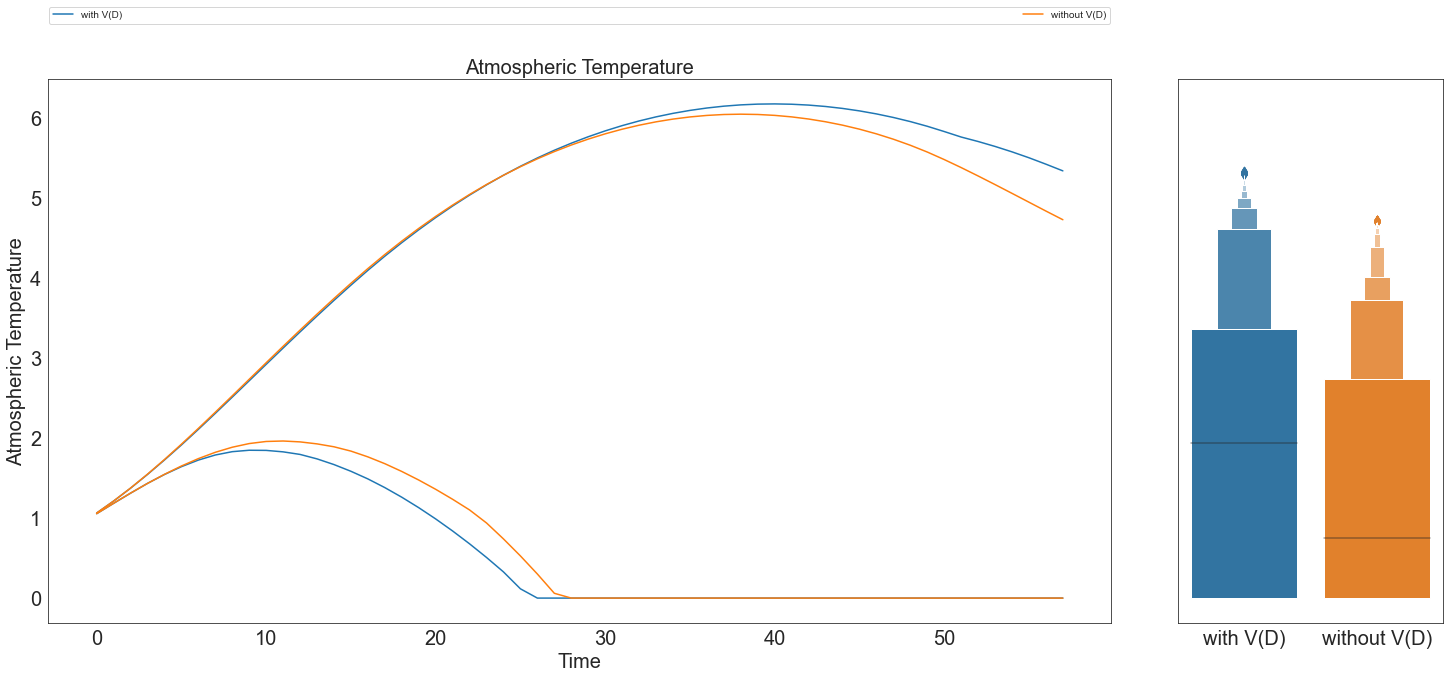

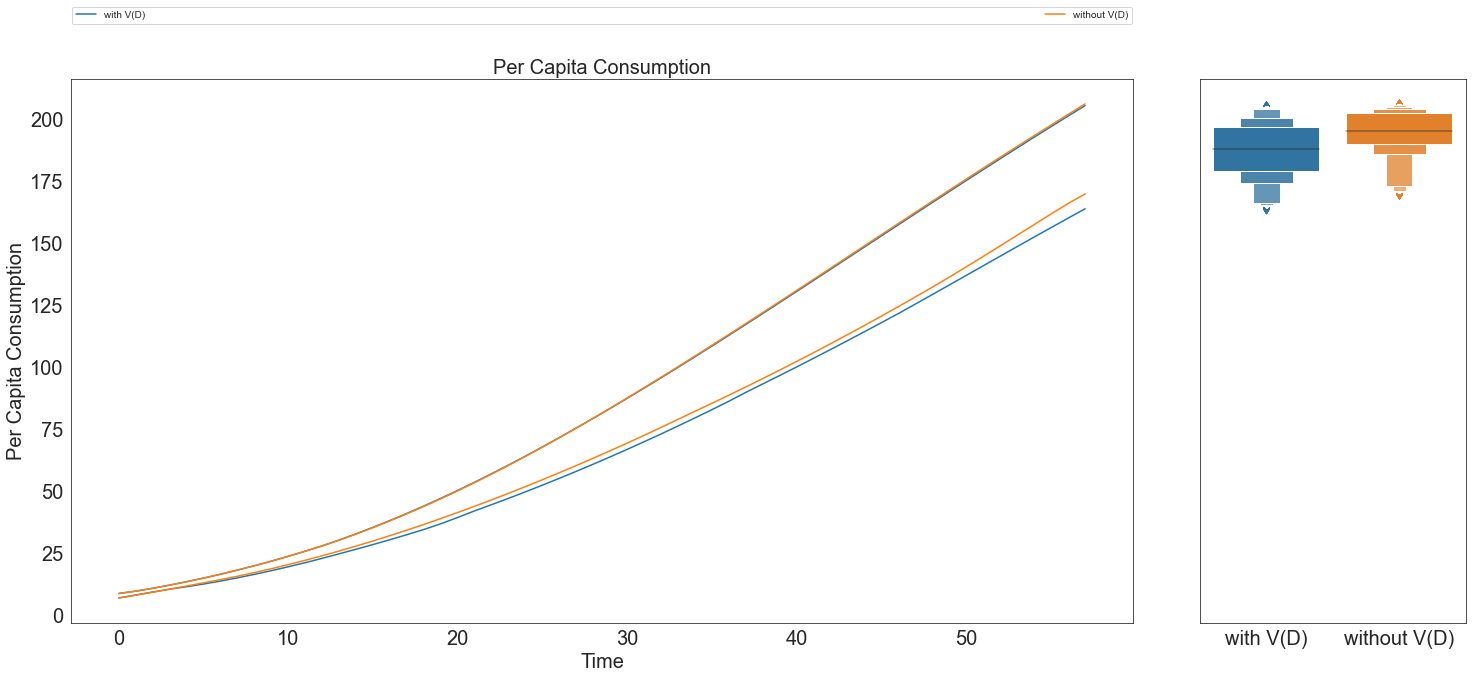

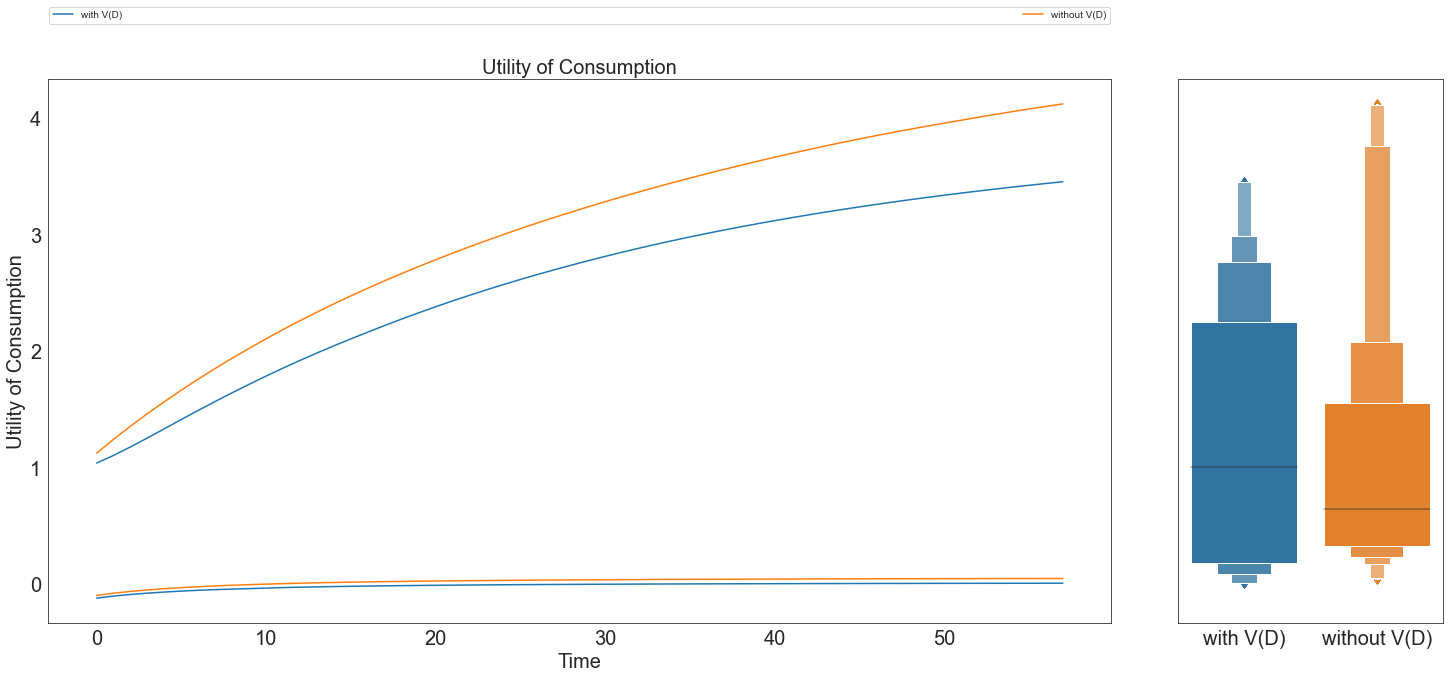

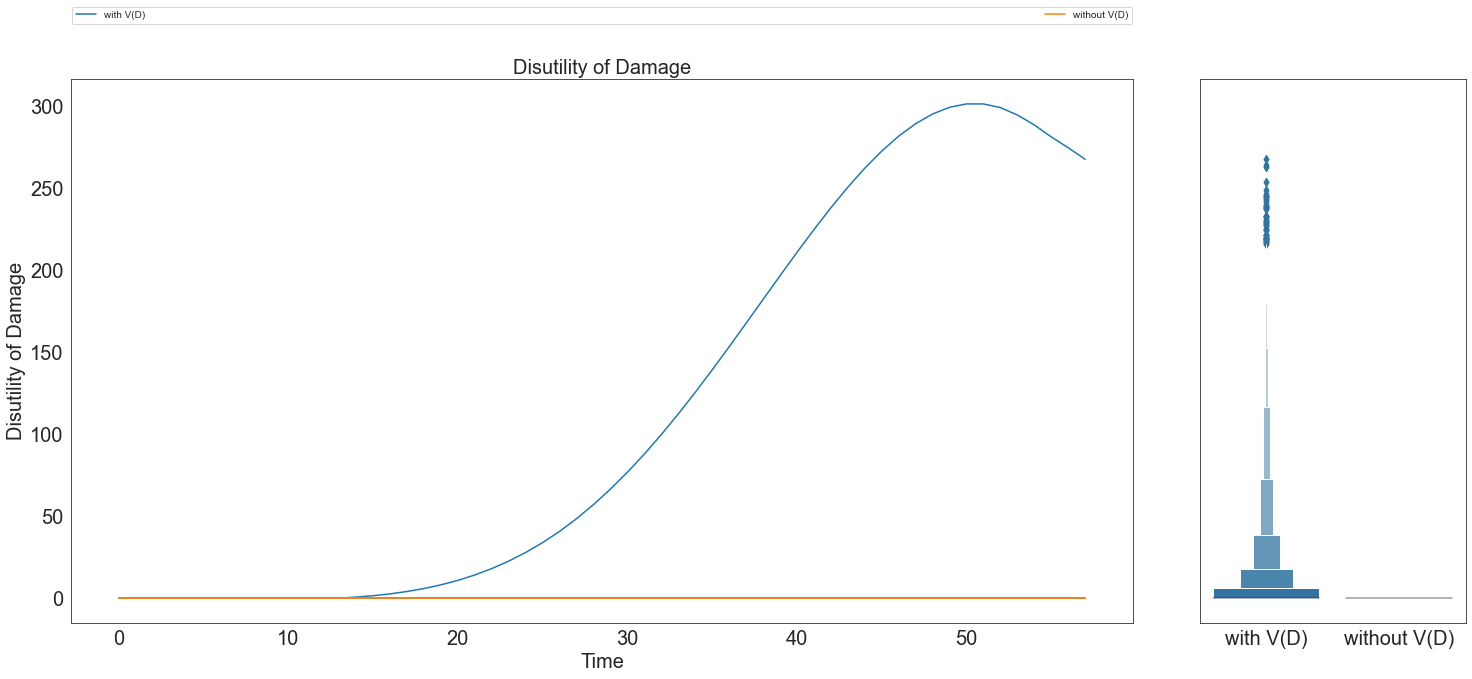

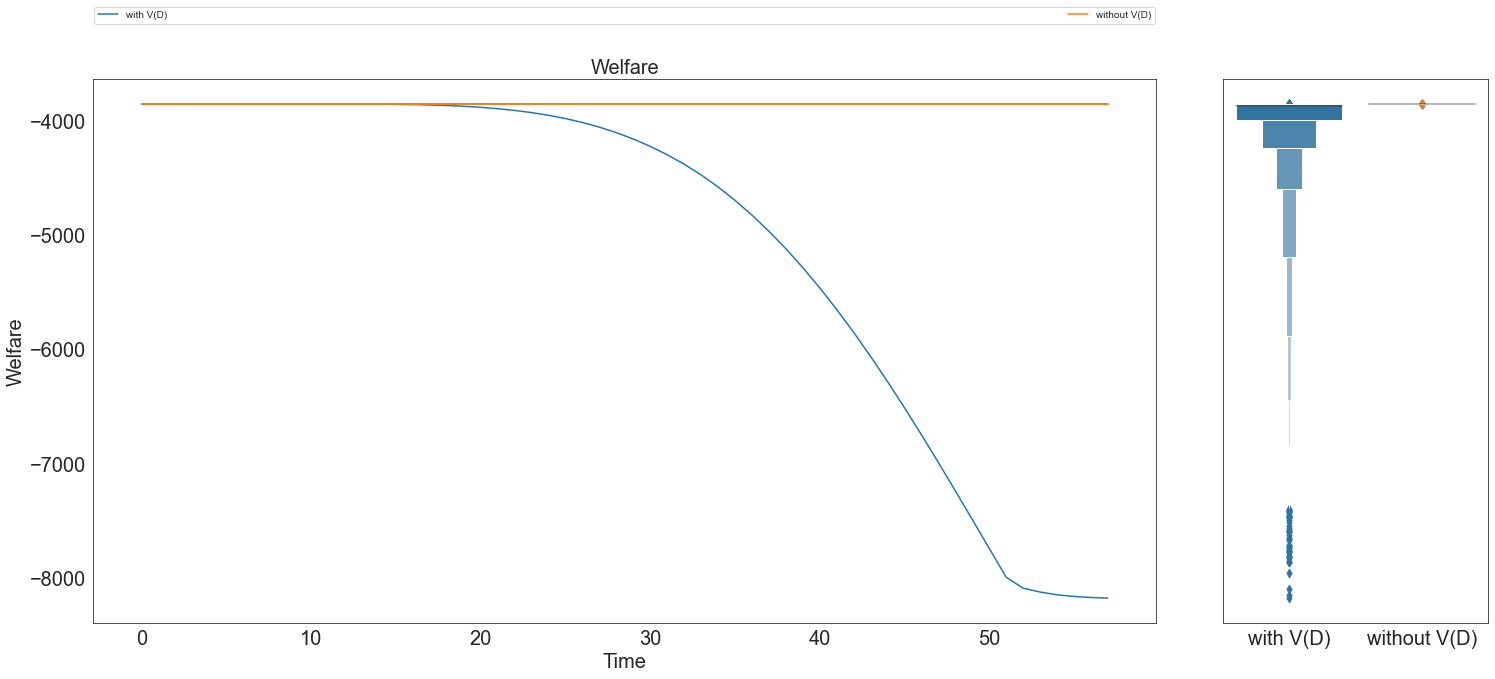

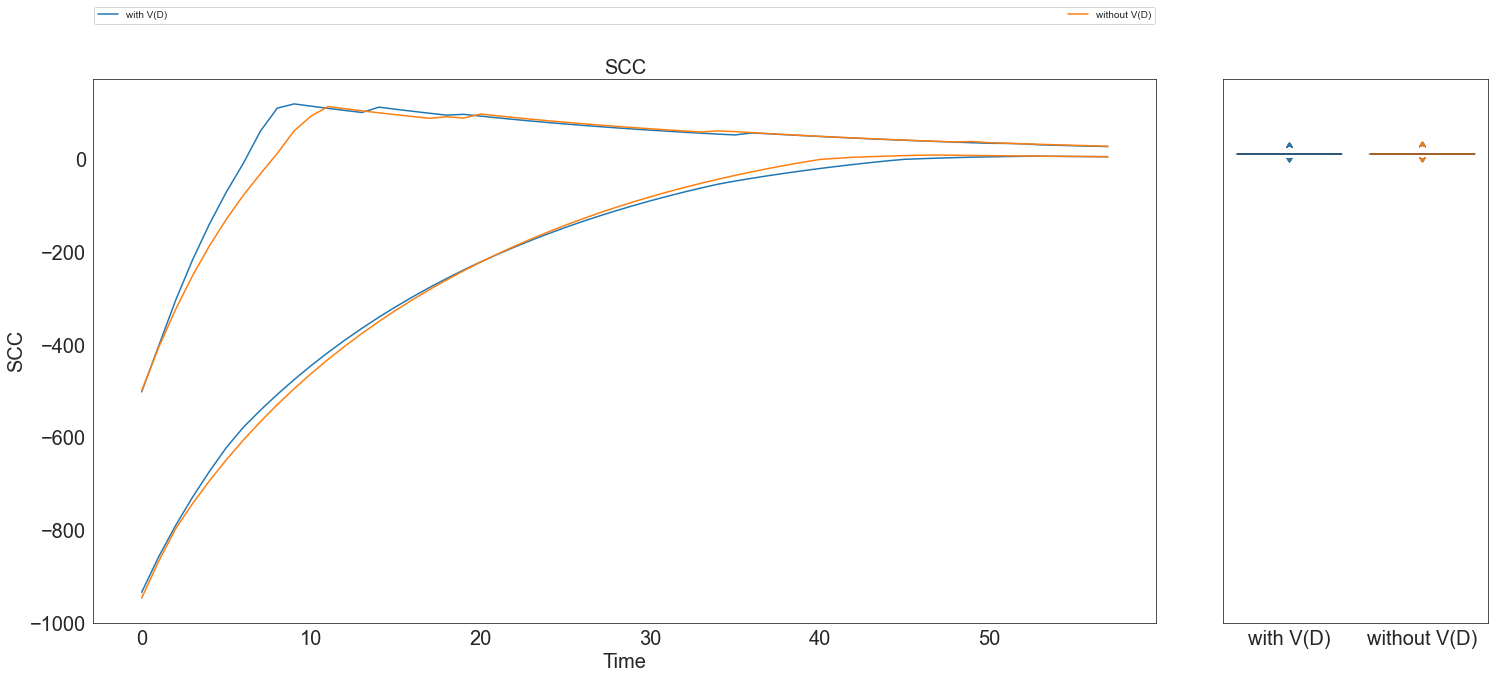

In [15]:
# Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 2
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


In [13]:
# Time series outcome grouped by V(D) switch

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.lines(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 1
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


NameError: name 'grouping_specifiers_VD' is not defined

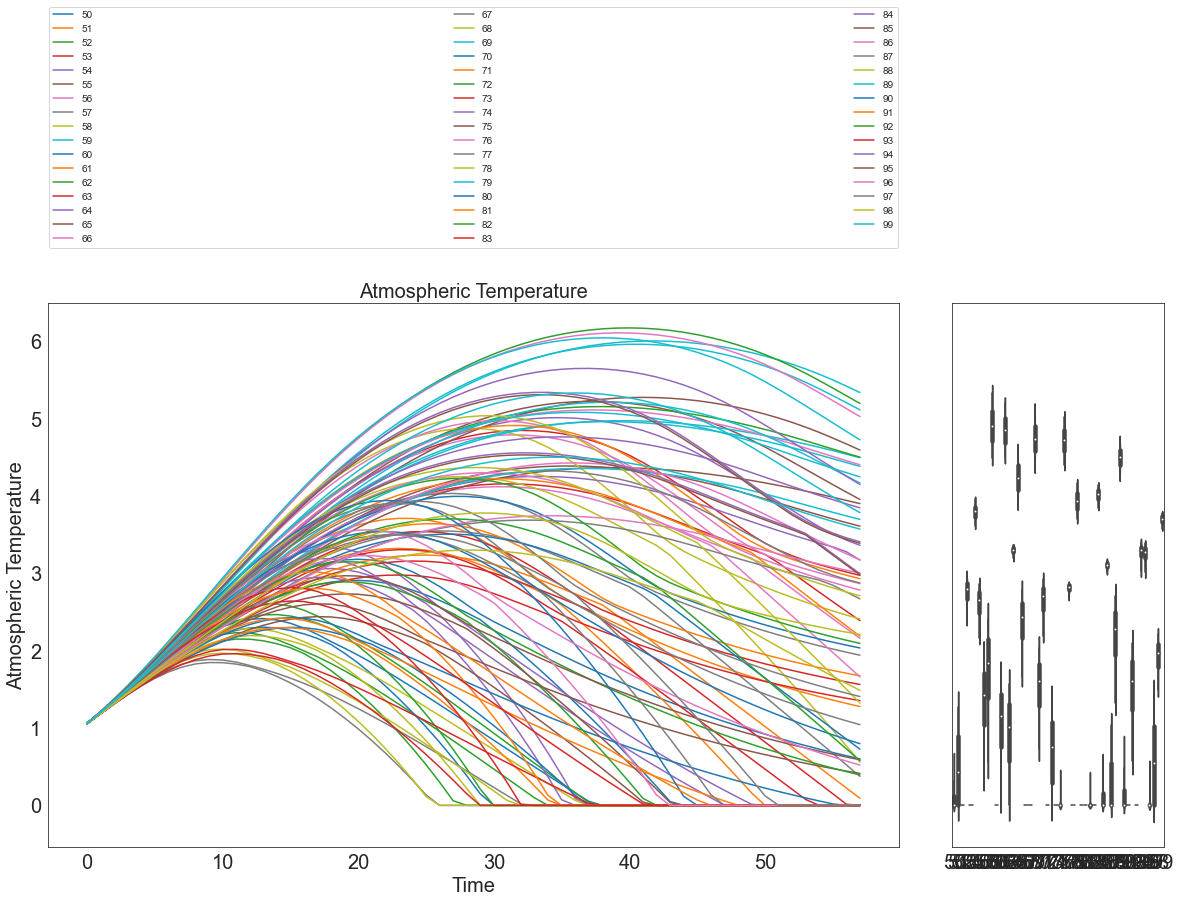

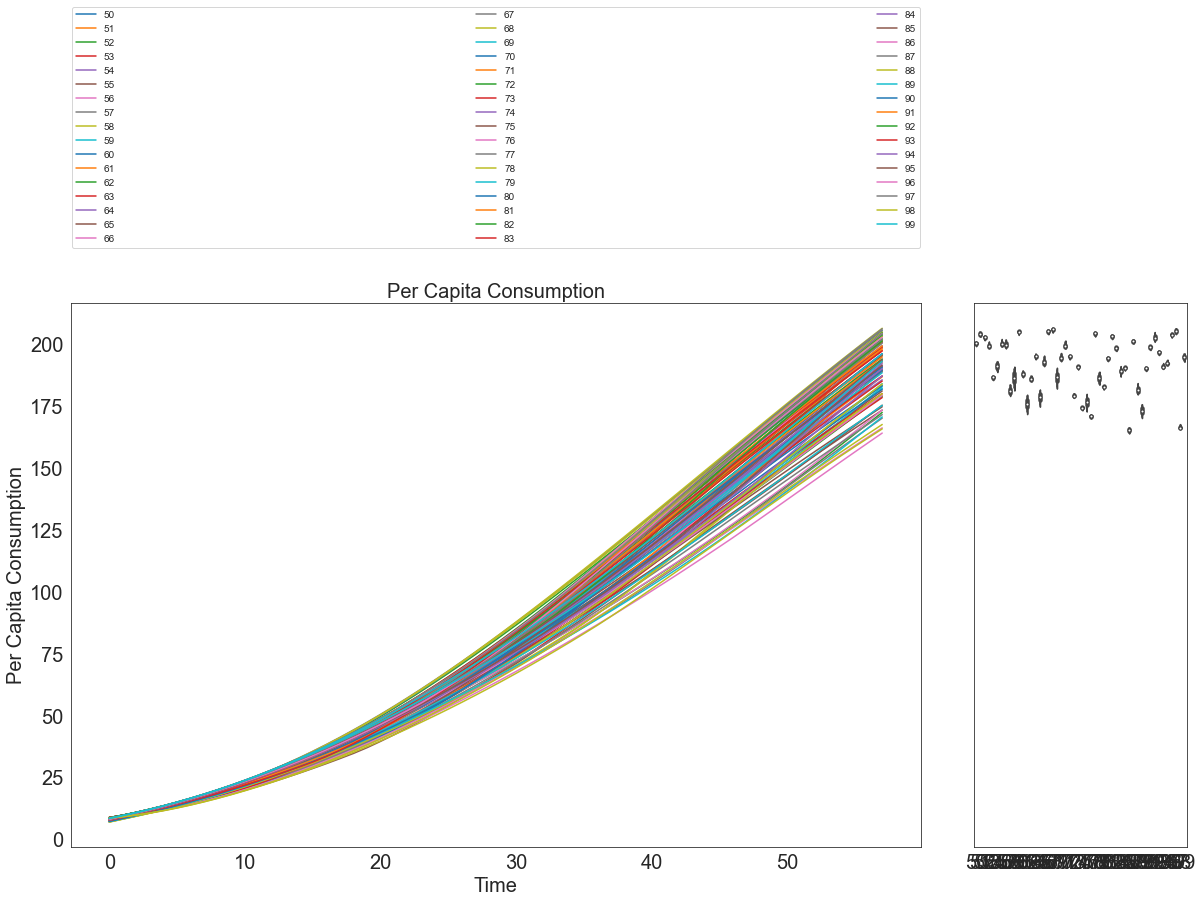

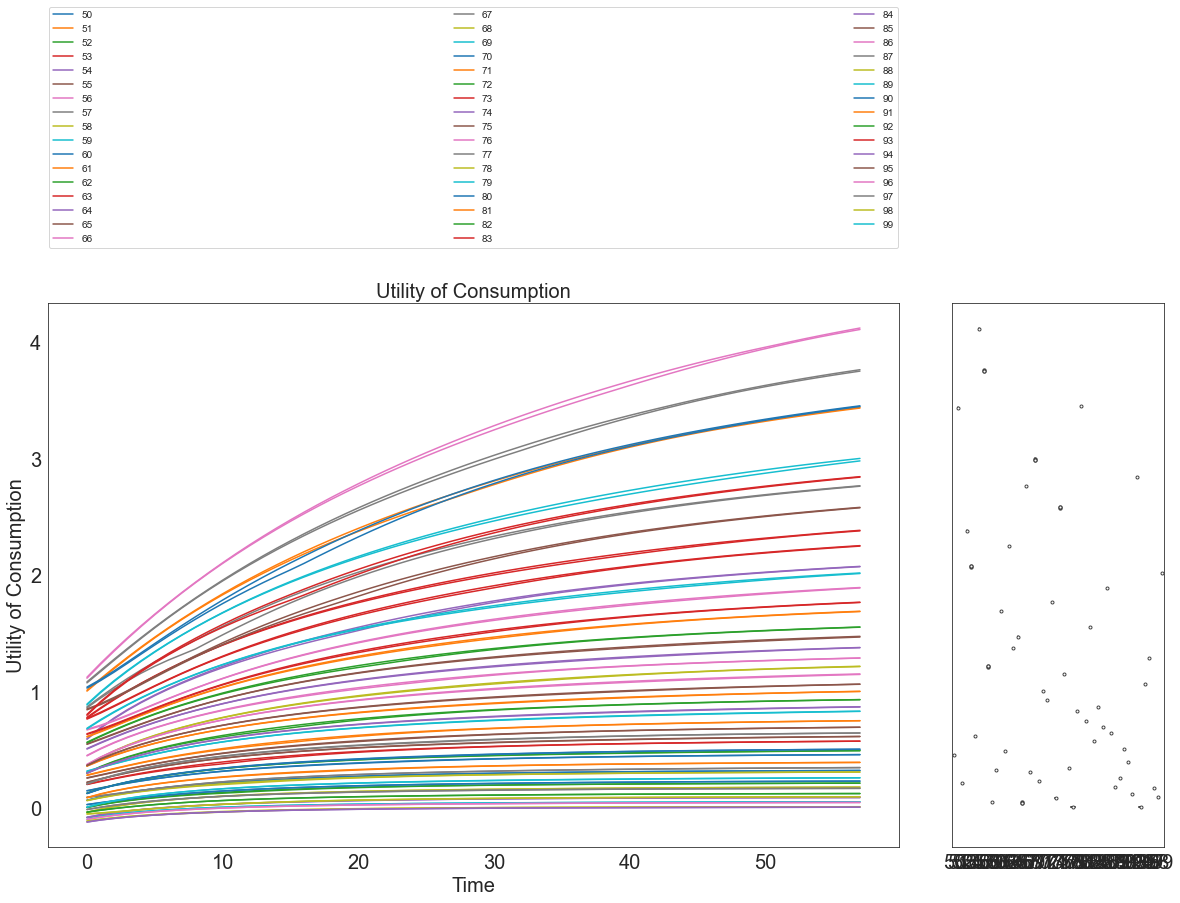

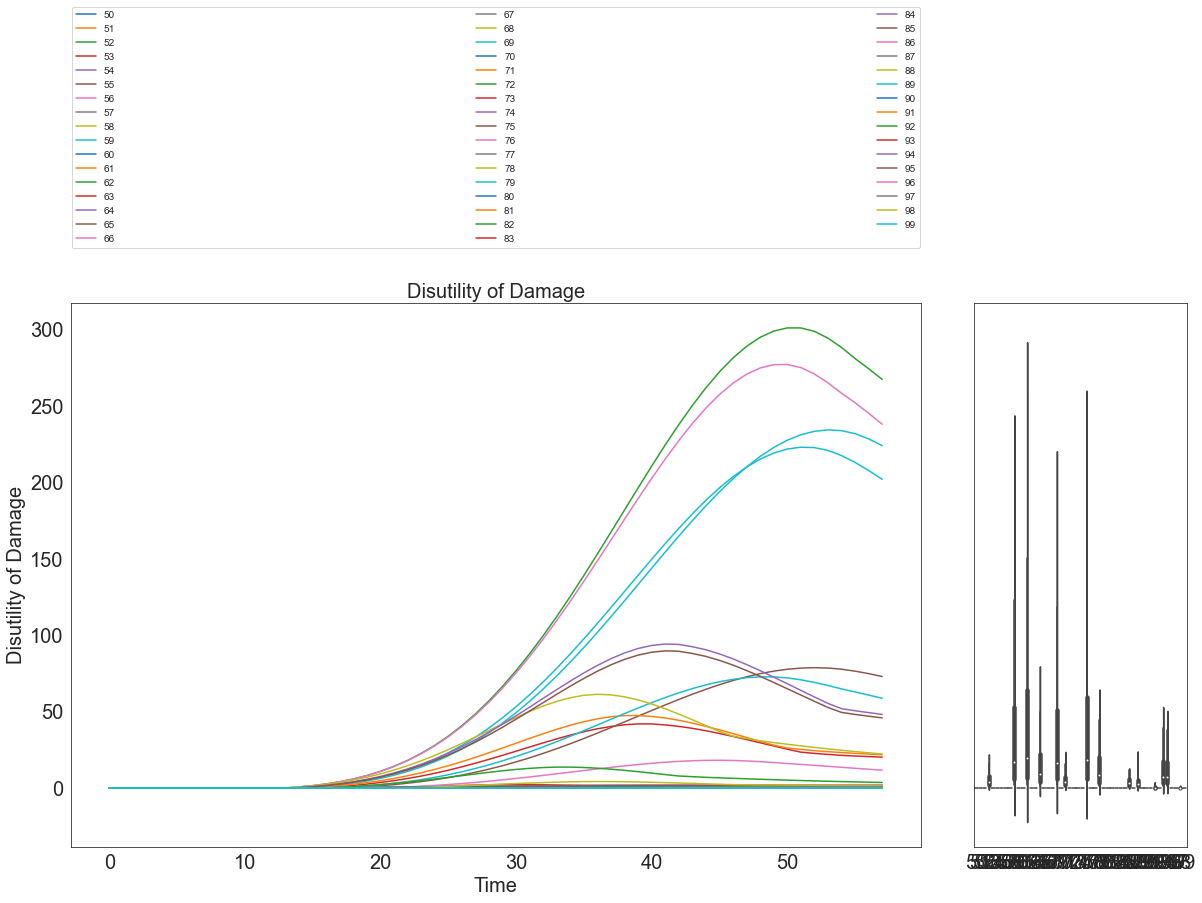

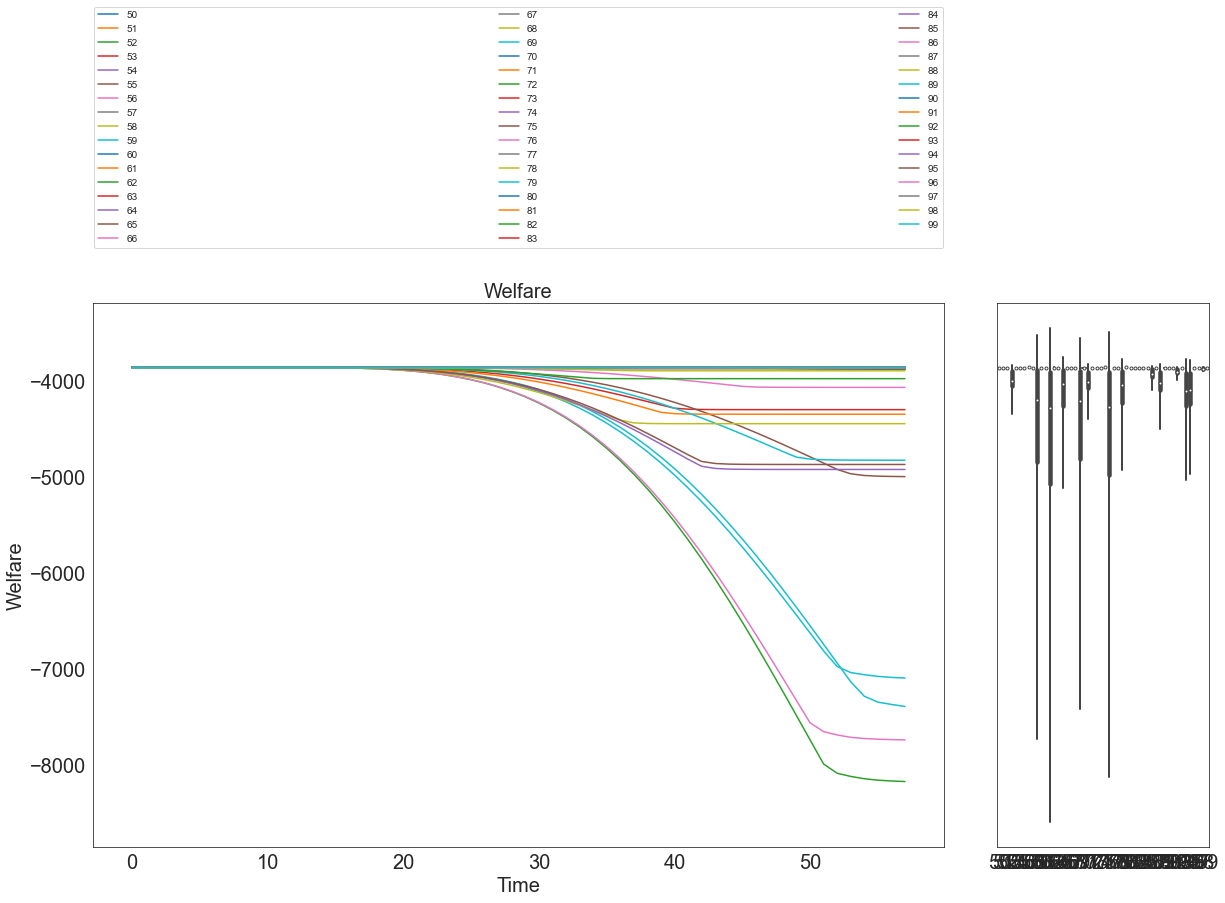

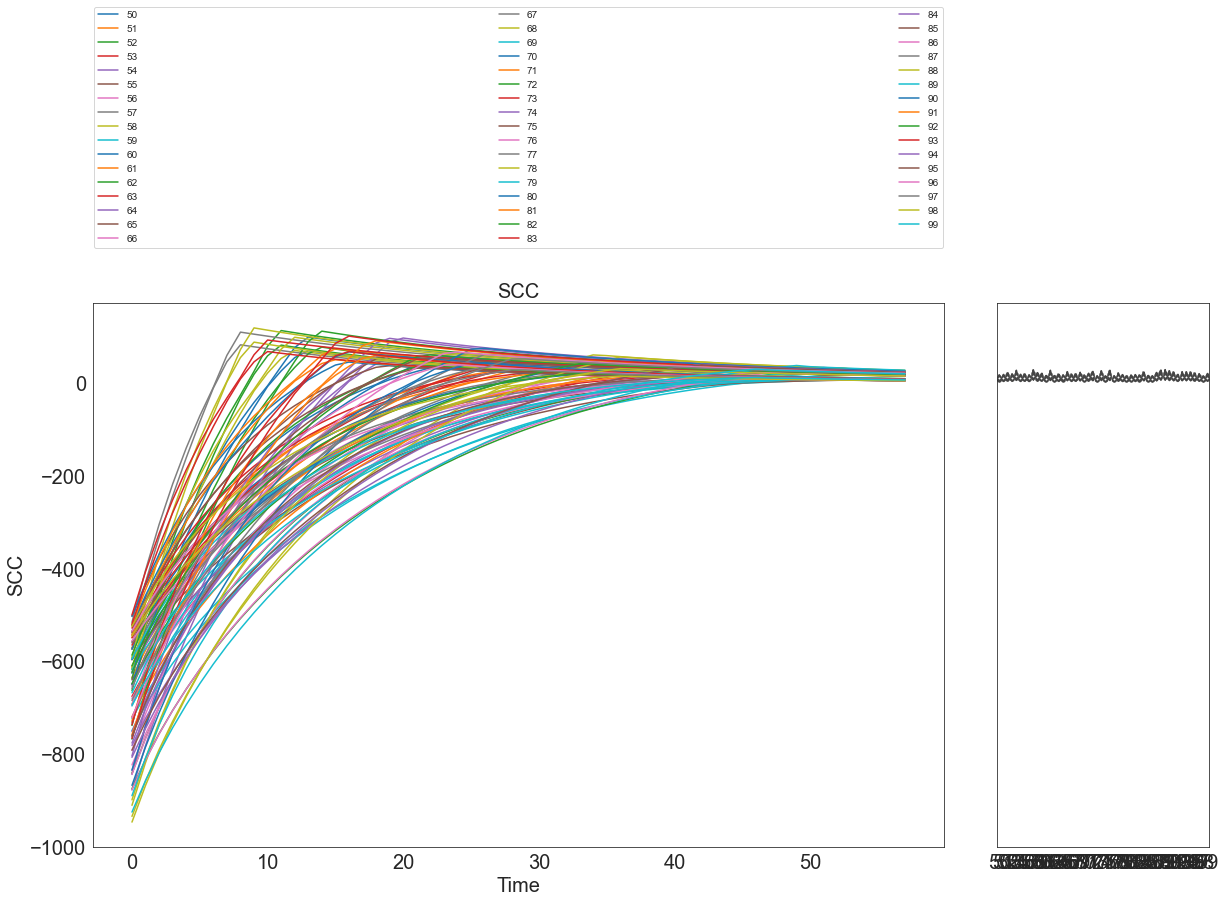

In [17]:
# Time series envelope outcome grouped by policy

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.VIOLIN, group_by='policy',legend=True)
    

    fig.set_size_inches(20, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 2
    # fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_policy_envelope_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


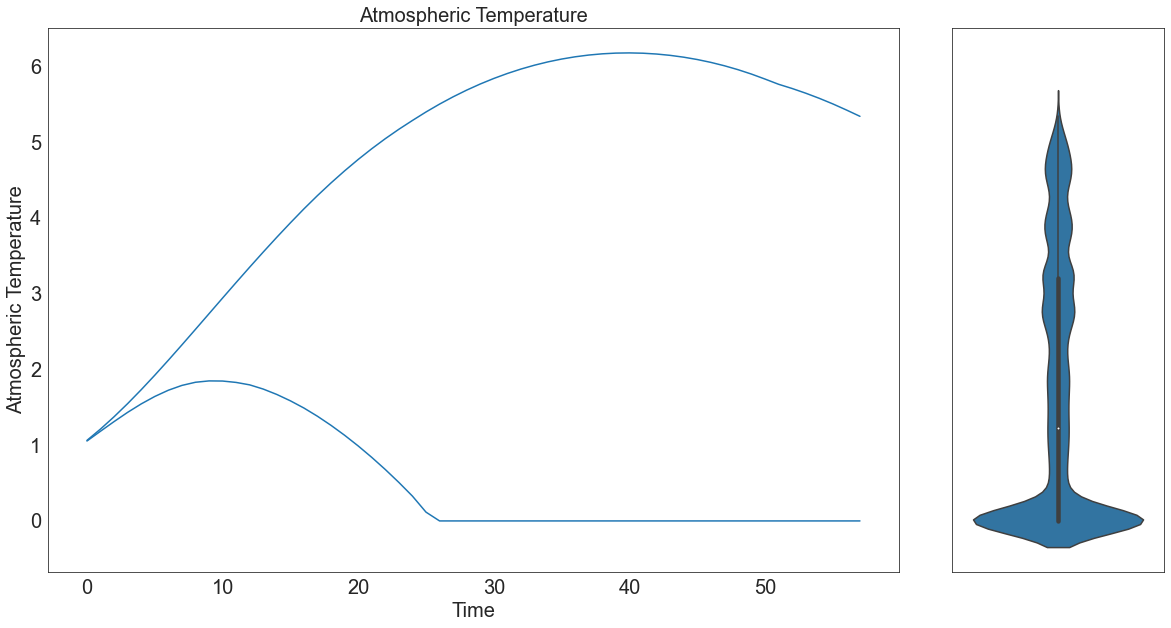

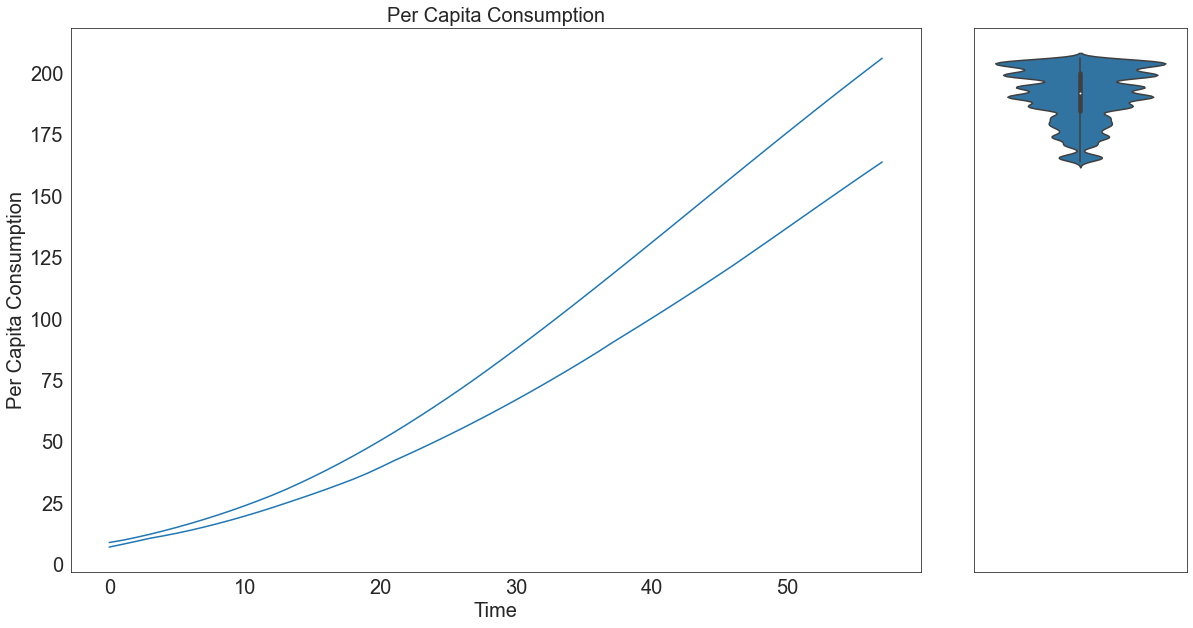

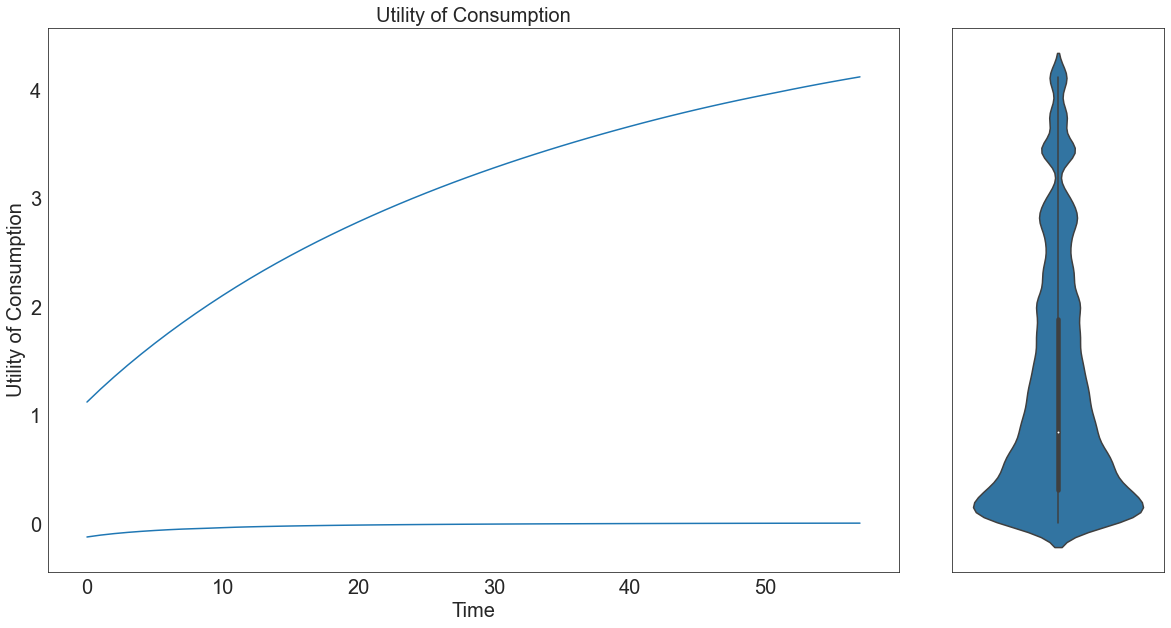

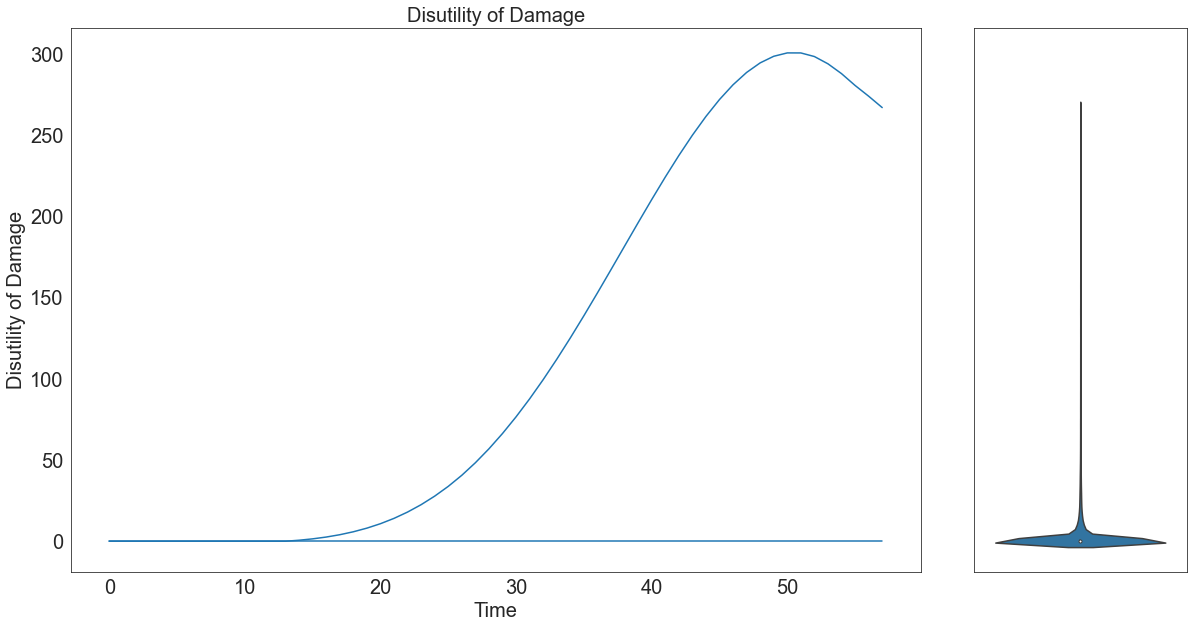

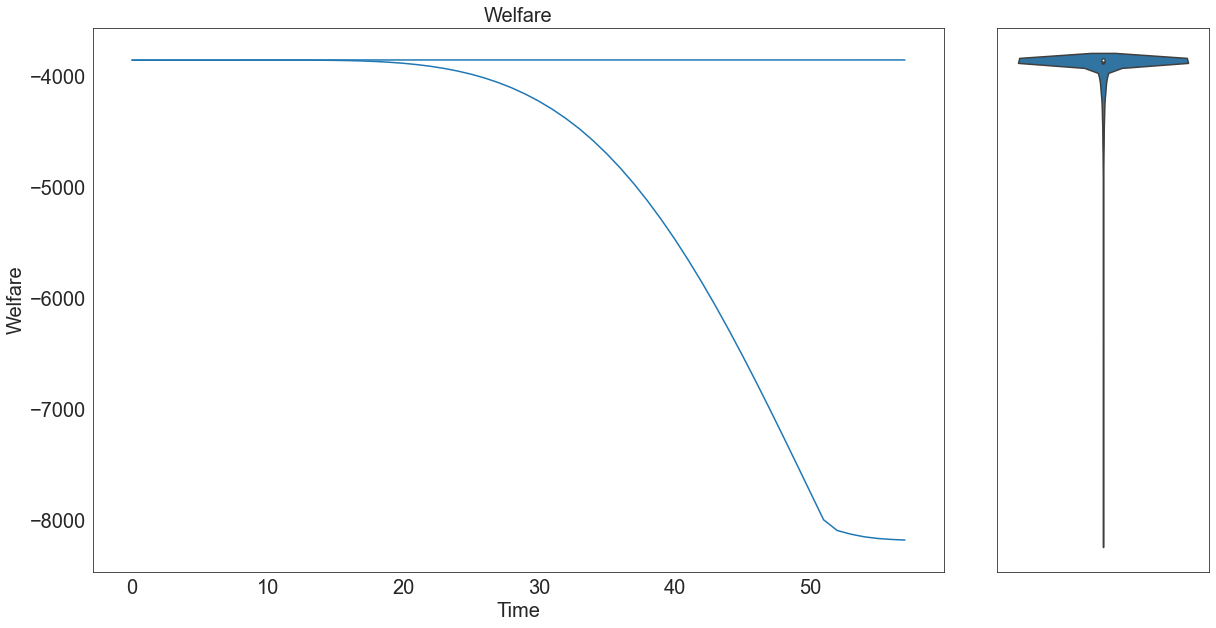

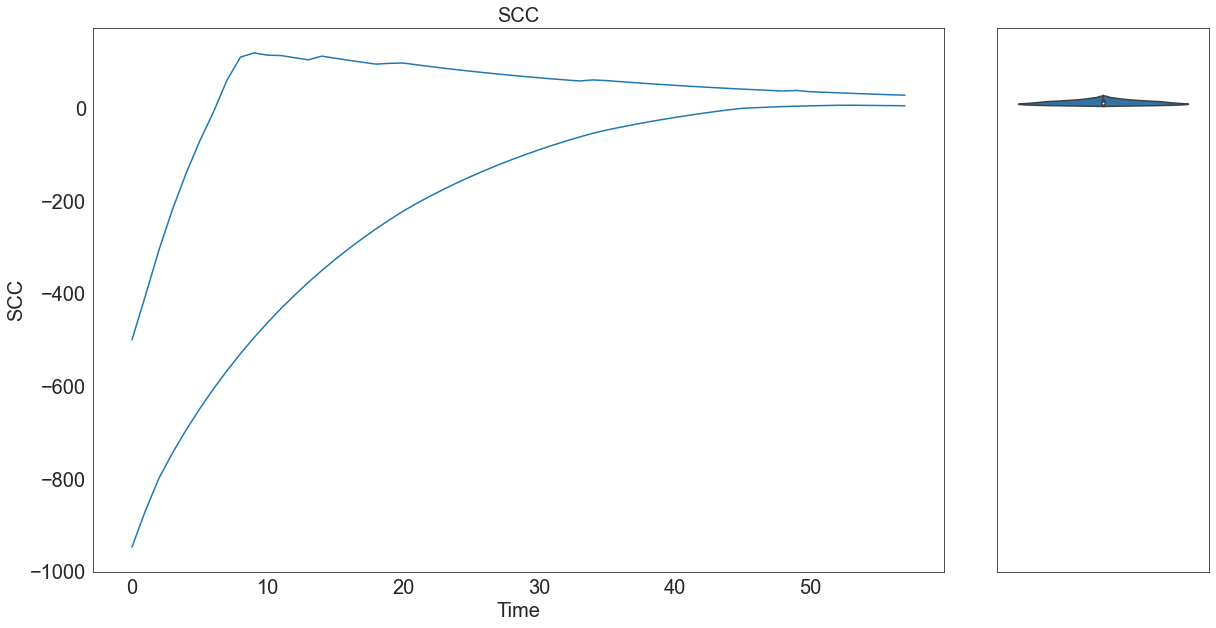

In [16]:
# Time series envelope outcome ungrouped

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT,legend=True)
    

    fig.set_size_inches(20, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 2
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_ungrouped_envelope_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


In [ ]:
outcome = 'Disutility of Damage'
fig,axes=plotting.envelopes(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

fig.set_size_inches(25, 10)
    
repeat_token = 1
fig.savefig(os.path.join(fig_path, str(run) + '1a_Time_grouped_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


In [ ]:
outcome = 'Welfare'
fig,axes=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='VD_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

fig.set_size_inches(25, 10)
    
repeat_token = 1
fig.savefig(os.path.join(fig_path, str(run) + 'Time_grouped_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()

In [ ]:
noutcomes = {}
for i in range(int(len(cleaned_outcome.keys())/5)):
    arr = np.stack((cleaned_outcome[x] for x in list(cleaned_outcome.keys()), axis=-1)
    key = list(cleaned_outcome.keys())
    noutcomes[key] = arr
noutcomes_wo_time = noutcomes.copy()